# UFO Project - Part 2
Welcome to an exploration of the mysterious and captivating world of UFO sightings! The existence of aliens has always been an interesting thing to wonder about. Altough most people (including myself) believe that we aren’t possibly the only living things in the entire universe, the question still remains: have aliens visited Earth in the past? In this project I aim to explore patterns of unidentified flying objects, examining how they interact with time, location, and human emotions. Let’s dive into the data and uncover what truths lie behind these sightings, and discover what the numbers reveal about our encounters with the unknown!

This is part 2 of my UFO sightings exploration project. In part 1, which was conducted using SQL, I performed an initial cleaning of the database. Now, in part 2, I will refine the database further to align with the specific questions and exploration goals I have in mind. 

There will be two parts to this notebook: 

[**Part 1:** Cleaning and Preperation](#clean-and-prep) <br>
In the cleaning and preperation section I will be doing a few main things:
1. [Change column data types](#change_dt)
2. [Reduce the size of the database](#red_db)
3. [Fill in NA values where possible](#fill_na)
4. [Create columns needed for text exploration](#text_col)
   
[**Part 2:** Analysis](#analysis) <br>
The analysis is going to be broken into four parts
1. [UFO vs Time](#vtime)
2. [UFO vs Location](#vloc)
3. [UFO vs Feelings](#vfeelings)
4. [UFO Comment Analysis](#comments)

At the end I will do an overall [summary](#summary) of all my findings.

## Load Libraries

In [112]:
import pandas as pd #data manipulation
import numpy as np #numerical computing
import csv 
import datetime 
import geopandas as gpd 
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from shapely.geometry import Point
import seaborn as sns # create statistical plots: line plot, kde plot, heatmap, violin plot, bar plot
from wordcloud import WordCloud
import matplotlib.colors as mcolors #to create cropped colourmap
from matplotlib.colors import ListedColormap #to create colormap for shapes vs sentiment bar plot
 
import plotly.express as px #Interactive over time
from geopy.exc import GeopyError #For filling in na countries
from geopy.geocoders import Nominatim

import nltk #for text analysis (natural language tool kit)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.tag import pos_tag
import text2emotion as te
import emoji 
from spacy.cli import download #for emotion

from PIL import Image #for wordcloud mask

from sklearn.cluster import DBSCAN #for cluster analysis
from sklearn.cluster import KMeans #world map k means clustering

from collections import Counter #for 10 words and sentimetns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read In Database

In [15]:
ufo = pd.read_csv('/Users/.../ufo.csv', sep = ";" )
ufo

,datetime,city,state,country,shape,comments,date_posted,latitude,longitude
0,1910-01-01 00:00:00,kirksville,mo,united states,disk,Historical sighting Northern Missouri,2005-09-15,40.194722,-92.583056
1,1944-01-01 12:00:00,san diego,ca,united states,cigar,A sighting of one silver or white enlongated c...,2004-07-25,32.715278,-117.156389
2,1945-01-01 12:00:00,ft lee,va,NaN,cigar,Multicolored object near Army base,2005-04-16,37.249053,-77.332431
3,1947-01-01 17:00:00,manama,NaN,NaN,circle,Slow moving circular craft whitnesses took ...,2009-03-19,26.216667,50.583333
4,1953-01-01 14:00:00,oklahomatexas border,tx,NaN,cigar,Copper cigarshaped object in early s,2008-03-31,33.660135,-97.715556
...,...,...,...,...,...,...,...,...,...
78218,2013-09-09 22:00:00,napa,ca,united states,other,Napa UFO,2013-09-30,38.297222,-122.284444
78219,2013-09-09 22:20:00,vienna,va,united states,circle,Saw a five gold lit cicular craft moving fastl...,2013-09-30,38.901111,-77.265556
78220,2013-09-09 23:00:00,edmond,ok,united states,cigar,witnesses miles apart Red amp White Elongate...,2013-09-30,35.652778,-97.477778
78221,2013-09-09 23:00:00,starr,sc,united states,diamond,On September ninth my wife and i noticed stran...,2013-09-30,34.376944,-82.695833


In [17]:
ufo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78223 entries, 0 to 78222
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     78223 non-null  object 
 1   city         78192 non-null  object 
 2   state        72360 non-null  object 
 3   country      69084 non-null  object 
 4   shape        78223 non-null  object 
 5   comments     78222 non-null  object 
 6   date_posted  78223 non-null  object 
 7   latitude     78223 non-null  float64
 8   longitude    78223 non-null  float64
dtypes: float64(2), object(7)
memory usage: 5.4+ MB


<a id="clean-and-prep"></a>
# **Cleaning and Preperation**
There are a couple of things I want to change about the database before I proceed.
1. Change datetime and date posted columns to datetime type
2. The database is so huge, I want to make it smaller and easier to work with. There is a disproportionate amount of sightings that take place in the United States, so I want to drop a bunch of these rows
3. Fill in country names for missing countries
4. I want to do a text analysis later so there are some changes I must do for this. First I will create a second version of the dataset called ufo_txt. I will alter this table by:
> i. Tokenzing the comments column <br>
> ii. Removing stop words <br>
> iii. Adding speech tags <br>
> iv. Stemming words <br>
> v. Lemmatizing words <br>
> vi. Get sentiments <br>
> vii. Assign emotions based on comments column
5. I want to investigate how long it takes for people to post about a UFO sighting after it happens. So I will create an extra column with the number of days between observation and posting.
6. I am going to create country specific colours, masks and databases. This is for the sake of uniformity, readability and simplicty later on.
7. Creating a few final decorative elemnts to be used later on.

<a id="change_dt"></a>
### 1. Change datetime and date posted type

In [19]:
ufo['datetime'] = pd.to_datetime(ufo['datetime'])
ufo['date_posted'] = pd.to_datetime(ufo['date_posted'])

ufo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78223 entries, 0 to 78222
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     78223 non-null  datetime64[ns]
 1   city         78192 non-null  object        
 2   state        72360 non-null  object        
 3   country      69084 non-null  object        
 4   shape        78223 non-null  object        
 5   comments     78222 non-null  object        
 6   date_posted  78223 non-null  datetime64[ns]
 7   latitude     78223 non-null  float64       
 8   longitude    78223 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 5.4+ MB


<a id="red_db"></a>
### 2. Drop "United States" Rows

In [21]:
print(ufo['country'].value_counts())

country
united states     63188
canada             2993
united kingdom     2251
australia           550
germany             102
Name: count, dtype: int64


In [23]:
us_rows = ufo[ufo['country'] == 'united states']

rows_to_drop = us_rows.sample(n = 63000, random_state=1)

ufo.drop(rows_to_drop.index, inplace=True)
ufo.reset_index(drop=True, inplace=True)

print(ufo['country'].value_counts())

country
canada            2993
united kingdom    2251
australia          550
united states      188
germany            102
Name: count, dtype: int64


<a id="fill_na"></a>
### 3. Fill in empty countries

In [29]:
geolocator = Nominatim(user_agent = "ufo_app")
allowed_countries = {'canada', 'united states', 'united kingdom', 'germany', 'australia'}

def country(row, cache={}):
    '''This function retrieves the country name based on latitude and longitude coordinates (using geocoding). 
    It caches the results to improve performance. Handles erreros by defaulting to 'other' if geocoding fails 
    or the country is not in the allowed list.
    :param row: The row of the database we are working on
    :param cache: A dictionary used to cache the country names based on coordinates
    :return: A string representing the name of the country
    '''
    
    coord = (row['latitude'], row['longitude'])
    
    if coord in cache:
        return cache[coord]
    try:
        location = geolocator.reverse(f"{coord[0]}, {coord[1]}", exactly_one = True)
        if location and 'address' in location.raw:
            country = location.raw['address'].get('country', '').lower()
            if country in allowed_countries:
                cache[coord] = country
                return country
            else:
                cache[coord] = 'other'
                return 'other'
                
    except GeopyError as e:
        print(f"GeopyError for coordinates {coord}")
    except Exception as e:
        print(f"Error for coordinates {coord}: {e}")

    cache[coord] = 'other'
    return 'other'

In [35]:
ufo["country"] = ufo.apply(lambda row: country(row) if pd.isnull(row['country']) else row['country'], axis=1)

print(ufo["country"].value_counts())

country
united states     5760
canada            3590
other             2734
united kingdom    2397
australia          640
germany            102
Name: count, dtype: int64


In [37]:
ufo.head()

,datetime,city,state,country,shape,comments,date_posted,latitude,longitude
0,1945-01-01 12:00:00,ft lee,va,united states,cigar,Multicolored object near Army base,2005-04-16,37.249053,-77.332431
1,1947-01-01 17:00:00,manama,NaN,other,circle,Slow moving circular craft whitnesses took ...,2009-03-19,26.216667,50.583333
2,1953-01-01 14:00:00,oklahomatexas border,tx,united states,cigar,Copper cigarshaped object in early s,2008-03-31,33.660135,-97.715556
3,1954-01-01 22:00:00,souix city,ia,united states,circle,Radar sighting Air Force base in Iowa feet...,2005-04-16,42.499994,-96.400307
4,1967-01-01 01:00:00,cam rahn bay,NaN,other,cigar,Saw UFO when in Viet Namno doubt about it,2007-04-27,11.893334,109.170167


<a id="text_col"></a>
### 4. Prep for text analysis

In [39]:
ufo_txt = ufo

#### i. Tokenize comments column

In [41]:
def tokenize_comments(comment):
    '''This function tokenizes a comment by splitting it into individual words and converting them to lowercase and removes 
    duplicates. (Tokenizes using word_tokenize from the NLTK library)

    :param comment: A string containing the comment to be tokenized.
    :return: A list of unique tokens extracted from the comment.
    '''
    try:
        return list(set(word_tokenize(comment.lower())))
    except:
        return []

#Create a new column containing the tokenized comment 
ufo_txt['tokenized comments'] = ufo_txt['comments'].apply(tokenize_comments)

#### ii. Remove stopwords

In [43]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokenized):
    '''This function takes a list of tokens and removes stopwords using a predefined set of stopwords (stop_words from above)

    :param tokenized: A list of tokens from which stopwords are to be removed.
    :return: A list of tokens with stopwords removed.
    '''
    filtered = []
    for word in tokenized:
        if word.lower() not in stop_words:
            filtered.append(word)
    return filtered

#Alter the tokenized comment column that contains the same list with the stopwords removed
ufo_txt['tokenized comments'] = ufo_txt['tokenized comments'].apply(remove_stopwords)

#### iii. Add speech tags

In [45]:
def add_tags(tokenized):
    '''This function takes a list of tokens and adds Part-of-Speech (POS) tags to each token using NLTK's `pos_tag` function
    
    :param tokenized: A list of tokens to add POS tags to
    :return: A list of tuples where each tuple contains a token and its corresponding POS tag.
    '''
    pos_tags = nltk.pos_tag(tokenized)
    return pos_tags

#Create a new column containing the tagged tokens
ufo_txt['tagged tokens'] = ufo_txt['tokenized comments'].apply(add_tags)

#### iv. Stem words

In [47]:
stemmer = PorterStemmer()

def stem_words(tokenized_comment):
    '''This function takes a list of tokens and stems each word using a stemming algorithm (Porter Stemmer). 

    :param tokenized_comment: A list of tokens to be stemmed.
    :return: A list of stemmed tokens.
    '''
    stemmed_words = []
    for word in tokenized_comment:
        stemmed_words.append(stemmer.stem(word))
    return stemmed_words

#Create new column containing the stemmed comment
ufo_txt['stemmed comments'] = ufo_txt['tokenized comments'].apply(stem_words)

#### v. Lemmatize words

In [49]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(tagged_comment):
    '''This function takes a list of tagged tokens, where each token is paired with its Part-of-Speech (POS) tag. 
    It lemmatizes each word based on its POS tag, focusing only on nouns, adverbs, and adjectives.

    :param tagged_comment: A list of tagged tokens to be lemmatized.
    :return: A list of lemmatized tokens.
    '''
    lemmatized_words = []
    for word in tagged_comment:
        if word[1].startswith("NN"): #Noun
            lemmatized_words.append(lemmatizer.lemmatize(word[0], pos='n'))
        elif word[1].startswith('R'): #Adverb
            lemmatized_words.append(lemmatizer.lemmatize(word[0], pos='r'))
        elif word[1].startswith('JJ'): #Adjective
            lemmatized_words.append(lemmatizer.lemmatize(word[0], pos='a'))
        else:
            lemmatized_words.append(word[0])
    return lemmatized_words

#Create new column containing the lemmatized comment
ufo_txt['lemmed comments'] = ufo_txt['tagged tokens'].apply(lemmatize_words)

#### vi. Get Sentiments

In [51]:
def sentiment_analysis(tokenized_comment):
    '''This function takes a list of tokens, joins them into a single sentence, and performs sentiment analysis 
    using VADER (Valence Aware Dictionary and sEntiment Reasoner). It returns a tuple containing the compound sentiment 
    score and the sentiment category (Positive, Negative, or Neutral) based on the compound score.

    :param row: A list of tokens representing a comment or sentence.
    :return: A tuple containing the compound sentiment score and the sentiment category.
    '''
    sentence = ' '.join(tokenized_comment)
    sentiment = SentimentIntensityAnalyzer().polarity_scores(sentence)
    
    if sentiment['compound'] >= 0.05:
        sentiment_category = "Positive"
    elif sentiment['compound'] <= -0.05:
        sentiment_category = "Negative"
    else:
        sentiment_category = "Neutral"

    return sentiment['compound'], sentiment_category

#Create two new columns: sentiment score (containing the compound score), and sentiment (containing if the sentiment is positive, negative or neutral)
ufo_txt['sentiment score'], ufo_txt['sentiment'] = zip(*ufo_txt['tokenized comments'].apply(sentiment_analysis))

#### vii. Assign emotions

In [54]:
def assign_emotion(comment):
    '''This function takes a comment and assigns a dominant emotion using the text2emotion library. 

    :param comment: A string containing the comment for emotion analysis.
    :return: A string containing the dominant emotion detected in the comment.
    '''
    if isinstance(comment, str):  
        emotions = te.get_emotion(comment)
        dominant_emotion = max(emotions, key = emotions.get)
        return dominant_emotion
    else:
        return None  # for non-string inputs

ufo_txt['emotion'] = ufo_txt['comments'].apply(assign_emotion)

ufo_txt.sample(3)

,datetime,city,state,country,shape,comments,date_posted,latitude,longitude,tokenized comments,tagged tokens,stemmed comments,lemmed comments,sentiment score,sentiment,emotion
7105,1986-04-30 23:00:00,kleinmachnowberlin,NaN,other,cylinder,Ich wurde beim Fernsehen gestoumlrtals ploumlt...,2003-12-19,52.407927,13.222711,"[beim, schienmeine, grelles, fernsehen, rannte...","[(beim, NN), (schienmeine, NN), (grelles, NNS)...","[beim, schienmein, grell, fernsehen, rannten, ...","[beim, schienmeine, grelles, fernsehen, rannte...",0.0000,Neutral,Happy
1102,2013-01-09 03:38:00,beaverdam,nb,canada,oval,Jumped up out of bed like I was woke up or sta...,2013-02-04,54.203611,-110.306667,"[ligh, looked, woke, outside, like, odd, start...","[(ligh, NN), (looked, VBD), (woke, JJ), (outsi...","[ligh, look, woke, outsid, like, odd, startl, ...","[ligh, looked, woke, outside, like, odd, start...",0.3400,Positive,Happy
5211,2004-02-06 22:50:00,egham,NaN,united kingdom,light,light in the sky with peculiar movements,2004-02-12,51.416667,-0.566667,"[movements, peculiar, sky, light]","[(movements, NNS), (peculiar, JJ), (sky, NN), ...","[movement, peculiar, sky, light]","[movement, peculiar, sky, light]",0.1531,Positive,Happy


In [59]:
ufo_txt["emotion"].value_counts()

emotion
Happy       6172
Fear        3758
Angry       2176
Sad         2046
Surprise    1070
Name: count, dtype: int64

### 5. Add column for time analysis 

In [61]:
def days_between(d1, d2):
    '''This function takes the day the UFO sighting occured and the date the sighting was posted and returns the number of days between them
        :param d1: The datetime of the UFO sighting occurrence.
        :param d2: The datetime of the sighting being reported.
        :return: An integer representing the number of days between the two datetime objects.'''
    return abs((d2 - d1).days)

In [63]:
ufo['reporting delay'] = ufo.apply(lambda row: days_between(row['datetime'], row['date_posted']), axis=1)
ufo.sample(3)

,datetime,city,state,country,shape,comments,date_posted,latitude,longitude,tokenized comments,tagged tokens,stemmed comments,lemmed comments,sentiment score,sentiment,emotion,reporting delay
13629,2002-08-06 22:30:00,sandila,NaN,other,light,It scratches and gives electric shocks to the...,2002-08-16,27.058549,80.516061,"[people, trail, open, electric, area, speed, s...","[(people, NNS), (trail, VBP), (open, JJ), (ele...","[peopl, trail, open, electr, area, speed, scra...","[people, trail, open, electric, area, speed, s...",-0.3818,Negative,Surprise,9
12296,1997-08-12 00:30:00,pilot butte,sa,canada,chevron,seen when observing the Perseid meteor shower ...,2000-12-02,50.466667,-104.416667,"[seen, perseid, observing, august, meteor, sho...","[(seen, VBN), (perseid, NN), (observing, VBG),...","[seen, perseid, observ, august, meteor, shower]","[seen, perseid, observing, august, meteor, sho...",0.0000,Neutral,Happy,1207
5775,2013-03-20 23:45:00,monastir,NaN,other,light,White light moving fast and making stops betwe...,2013-05-15,35.783333,10.833333,"[fast, moving, points, making, white, sky, lig...","[(fast, RB), (moving, VBG), (points, NNS), (ma...","[fast, move, point, make, white, sky, light, s...","[fast, moving, point, making, white, sky, ligh...",-0.1531,Negative,Surprise,55


### 6. Country Specific Information

In [65]:
#Canada specific db
ufo_text_ca = ufo_txt[ufo_txt["country"] == "canada"]

#Australia specifc db
ufo_text_aus = ufo_txt[ufo_txt["country"] == "australia"]

#United States specifc db
ufo_text_us = ufo_txt[ufo_txt["country"] == "united states"]

#Germany specifc db
ufo_text_ger = ufo_txt[ufo_txt["country"] == "germany"]

#United Kingdom specifc db
ufo_text_uk = ufo_txt[ufo_txt["country"] == "united kingdom"]

#Other country db
ufo_text_else = ufo_txt[ufo_txt["country"] == "other"] 

### 7. Creating decorative elements

In [67]:
sns.set_theme(style = "white")

#Create colour for heatmap: If its colder its less dense, if its warmer its more dense
original_cmap = plt.get_cmap('twilight')
cropped_cmap = mcolors.LinearSegmentedColormap.from_list("cropped_cmap", original_cmap(np.linspace( 0.05 , 0.8, 256)))

#Create Masks for Wordclouds
ufo_mask = np.array(Image.open('/Users/.../ALIEN.jpg'))
sattelite_mask = np.array(Image.open('/Users/.../SAT.png'))
star_mask = np.array(Image.open('/Users/.../STAR.jpeg'))
astro_mask = np.array(Image.open('/Users/.../ASTRONAUT.jpg'))
saturn_mask = np.array(Image.open('/Users/.../SATURN.png'))
rocket_mask = np.array(Image.open('/Users/.../ROCKET.png'))
ufo2_mask = np.array(Image.open('/Users/.../UFO.jpg'))

***

<a id="analysis"></a>
# **Analysis Begins (The fun part!)**
Okay now that all of that is out of the way, we can finally begin doing some interesting stuff!
<a id="vtime"></a>
## 1) UFOs vs Time
How can we analyze time with respect to UFO sightings?
- I want to investigate different factors relating to UFO sightings over the years:
> i. Number of sightings <br>
> ii. Number of reports
- I want to investigate reporting delays for different categories:
> i. Country <br>
> ii. Emotion <br>
> iii. Shape

### Sightings, and Reporting Over the Years
Questions to investigate:
- Is there a steady increase in UFO sighting rates over the years? (and how about for different countries?) 
- Is there a steady increase in reporting rates over the years? (and how about for different countries?) 
- What are some possible reasons for this?

#### i. Number of Sightings 

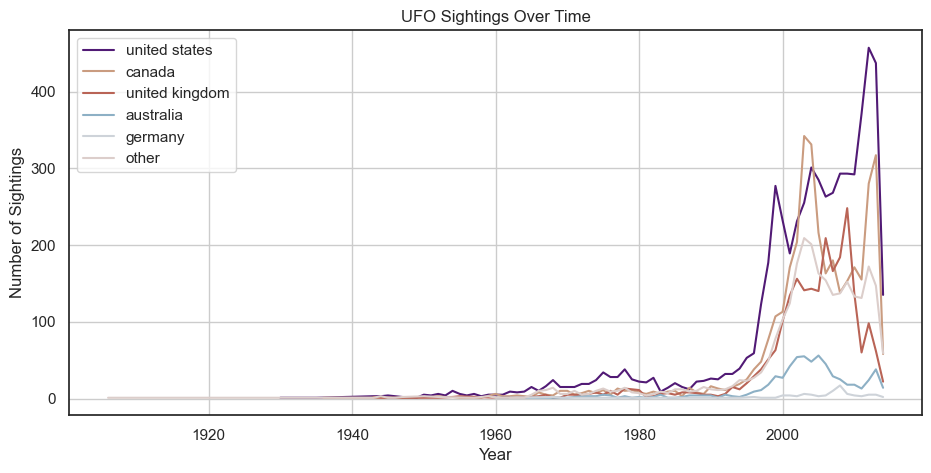

In [69]:
countries = ['united states', 'canada', 'united kingdom', 'australia', 'germany', 'other'] 
colours =  ['#511a75', '#ca9c80', '#b96456', '#8db0c5', '#ced3d9', '#dccecb' ] 

plt.figure(figsize = (11, 5)) 

# Plot line graphs for each country and UFO sightings
for i in range(len(countries)):
    ufo_country = ufo[ufo['country'] == countries[i]]
    ufo_per_year_country = ufo_country['datetime'].dt.year.value_counts().sort_index()
    sns.lineplot(x = ufo_per_year_country.index, y = ufo_per_year_country.values, label = countries[i], color = colours[i])

plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.title('UFO Sightings Over Time')
plt.legend()

plt.show() 

- All countries seem to have a spike in UFO sightings after 1995. This could be for a number of reasons
    - **Internet:** In 1995 commercial Internet access started to be sold to consumers. According to Wikipedia, the Internet only communicated 1% of the information flowing through two-way telecommunications networks in the year 1993, 51% by 2000, and more than 97% of the telecommunicated information by 2007 (__[History of the Internet](https://en.wikipedia.org/wiki/History_of_the_Internet#:~:text=The%20Internet's%20takeover%20of%20the,the%20telecommunicated%20information%20by%202007./)__).
    - **Pop Culture Influence:** The popularity of alien movies started to increase from the 80's to the 90's. But some significant movies about aliens were released after 1995 such as *Independence Day* (1996), and *Men in Black* (1997) just to name a few. With all the buzz around the topic of aliens, it is likely that more people were on the lookout for UFOs or they were more likely to interpret a strange event in the sky as a UFO
    - **Conspiracy Theories:** Bob Lazar (one of the most famous alien and Area 51 conspiracy theorists) began to speak publicly about his claims of working on an alien spacecraft at Area 51's S-4 facility. His first public television interview in 1989 sparked widespread discussion and raised interest and controversy. This interview also caused further media coverage and discussions about UFOs and government secrecy about possible alien technology.
- Note that there seems to be a declining trend in 2014. But this is probably due to the fact that we only have data for the first five months of 2014.
- Canada seems to have had a huge spike in sightings around 2005. After searching online I was not able to find any major alien-related events happening in Canadian media around this time. After some more searching, I found out that several notable UFO sightings took place during the years 2003-2007. (__[UFO & Alien Sightings by Location](https://www.thinkaboutitdocs.com/library/ufo-alien-sightings-location/)__). The only possible conclusion we can make from this is that Canada was a hotbed for alien tourists during those years. Perhaps it even made it onto the Martian "Top 10 Planets You Must Visit in the Milky Way" list! After all, Canada is the most friendly place in the galaxy!

#### ii. Number of Reports

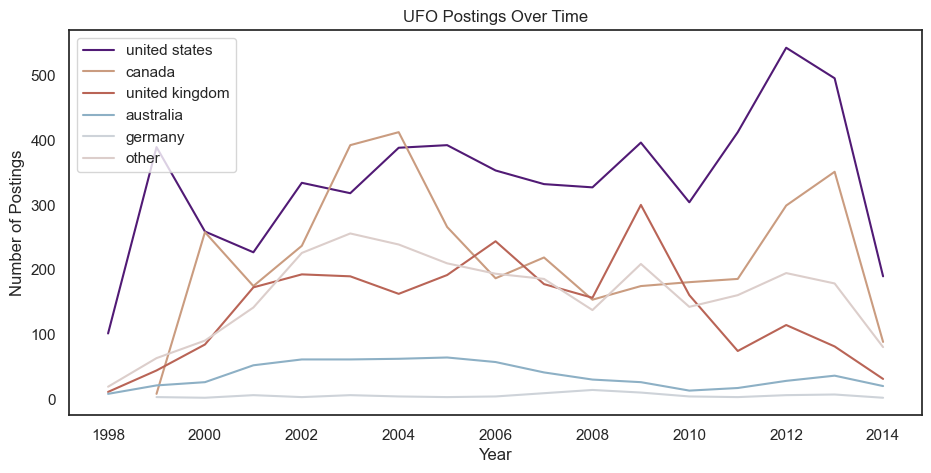

In [71]:
# Plot line graphs for each country and date posted 
plt.figure(figsize = (11, 5)) 
for i in range(len(countries)):
    ufo_country = ufo[ufo['country'] == countries[i]]
    ufo_per_year_country = ufo_country['date_posted'].dt.year.value_counts().sort_index()
    sns.lineplot(x = ufo_per_year_country.index, y = ufo_per_year_country.values, label = countries[i], color = colours[i])
    
plt.xlabel('Year')
plt.ylabel('Number of Postings')
plt.title('UFO Postings Over Time')
plt.legend()

plt.show() 

- Notice that the first posts don't appear until 1998. The initial spike in posts might be a result of the increasing availability of the internet to the general public in the late 90s, allowing people to share their experiences from earlier times.
- Canada had a spike in posts around 2005 (this makes sense as we previously figured out that Canada was a hotspot for alien tourism around that time)
- All countries saw a spike in posts around 2012 (this reflects the spike in sightings in 2012 from the graph above). The first thing that popped into my head as to why this could be is the idea that the world was going to end in 2012 based on the Mayan calendar (__[2012 End of the World](https://en.wikipedia.org/wiki/2012_phenomenon)__). Many people believed that the end of the Mayan Long Count calendar signaled the end of the world or the beginning of a new era. This event garnered widespread attention and speculation about potential apocalyptic scenarios, including alien invasions or contact.
  - Additionally, Men in Black 3 came out this year.
- For the most part, these lines ebb and flow (much like the popularity of the topic of aliens as public interest also ebbs and flows)

### How long does it take people to report UFO sightings? (Reporting Delays)
Questions to investigate:
- How quickly do people usually post?
- Does the reporting delay differ from country to country?
- What are some possible reasons for this?
- Do different UFO shapes effect the reporting delay? (Maybe some shapes are scarier than others)
- How does peoples emotions affect reporting delay?

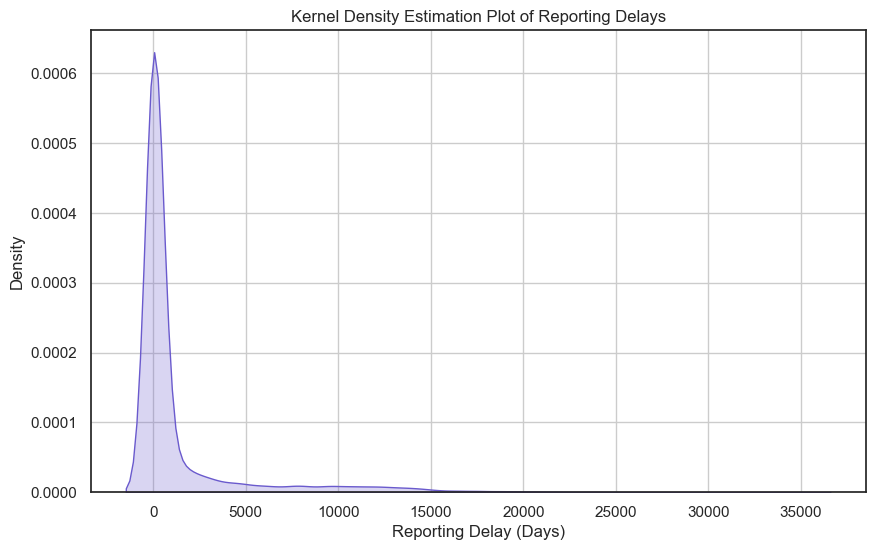

In [75]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=ufo, x='reporting delay', color='slateblue', fill=True)
plt.title('Kernel Density Estimation Plot of Reporting Delays')
plt.xlabel('Reporting Delay (Days)')
plt.grid(True)
plt.show()

- Most reports are posted close to the time of observation
- The plot seems to be decreasing -- meaning that it is more common that a post is made sooner rather than later after a UFO sighting occurs

### i. Reporting Delay vs. Country

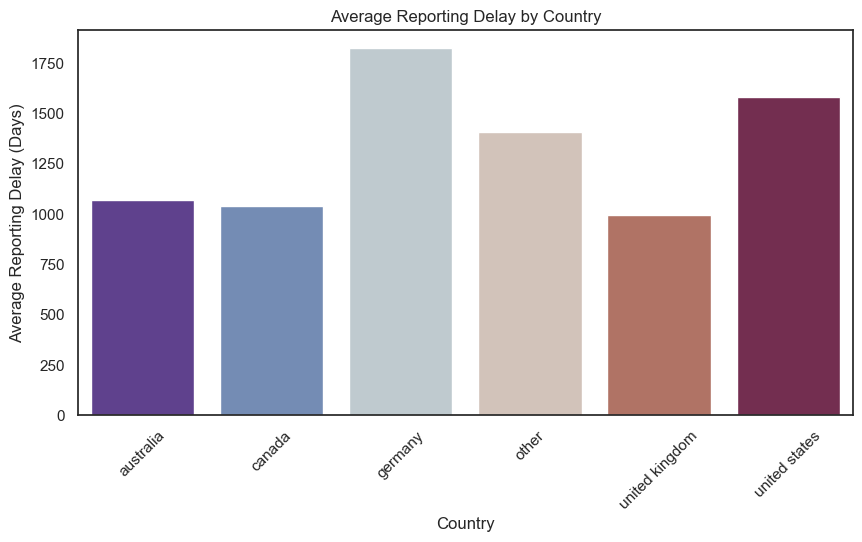

In [77]:
country_reporting_delay = ufo.groupby('country')['reporting delay'].mean().reset_index()

# Bar plot for averagr reporting delay by country
plt.figure(figsize = (10, 5))
sns.barplot(data = country_reporting_delay, x = 'country', y = 'reporting delay', palette = 'twilight_shifted')
plt.title('Average Reporting Delay by Country')
plt.xlabel('Country')
plt.ylabel('Average Reporting Delay (Days)')
plt.xticks(rotation = 45)

plt.show()

The ranking of countries by average reporting delay for UFO sightings can be influenced by various cultural, social, and media factors, as well as public interest and awareness. Here are some interesting observations from the graph:\
**1. Germany's Long Reporting Delay:**  The long reporting delay in Germany could be a result of cultural attitudes towards UFO sightings. This might be due to a more skeptical or reserved approach to something that appears otherworldly.\
**2. United States' Unexpected Position:** I was not expecting the United States to have the third slowest reporting time. So I really had to think about this one. Here are a few possible explanations:
* While there are many UFO enthusiasts in the U.S., there's also a stereotype that these people are "tinfoil hat" types. This could make others hesitant to report sightings for fear that they will be lumped together with this community.
* The fast-paced lifestyle in America might cause delays, as people prioritize other activities over reporting a UFO sighting.
* A huge population of hardcore alien believers live in America, this means they might take more time to gather details and ensure the accuracy of their reports before submitting them. This thoroughness can lead to longer reporting delays as individuals try to provide as much information as possible.
* Extensive media coverage of UFOs and Aliens might make people feel less urgent about reporting, thinking their sighting isn't unique or that someone else will report it.
* The United States is large and diverse, with regional differences in attitudes towards UFO sightings. In some areas, people might be more hesitant to report due to local cultural attitudes or norms.

### ii. Reporting Delay vs. Emotion

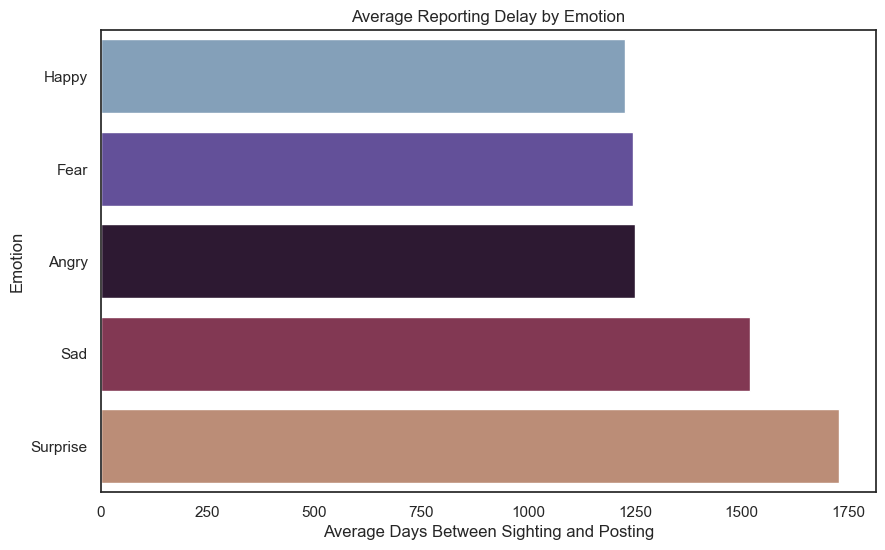

In [79]:
emotion_delay = ufo.groupby('emotion')['reporting delay'].mean().sort_values()

# Plot bar graph of average reporting delay vs emotion
plt.figure(figsize = (10, 6))
sns.barplot(x = emotion_delay.values, y = emotion_delay.index, palette = 'twilight')
plt.xlabel('Average Days Between Sighting and Posting')
plt.ylabel('Emotion')
plt.title('Average Reporting Delay by Emotion')
plt.show()

**Quick response times** <br>
Happy, scared, and angry observers tend to post about the encounters the quickest. These emotions are very strong and they are the kind of emotions that people most want to share with others. 
     
**Slower response times** <br>
In contrast, the delayed reporting of sadness and surprise is probably due to the complex nature of these emotions. Sadness, an emotion known to deplete energy and cause people to withdraw, may delay communication as people deal with or process their emotions. On the other hand, the delayed understanding that comes with surprise shows that people need time to process and make sense of unexpected experiences based on what they already know.

### iii. Reporting Delay vs. Shape
Just to have some context for this exploration I want to see just a bar graph of the amount of times each shape has been reported.

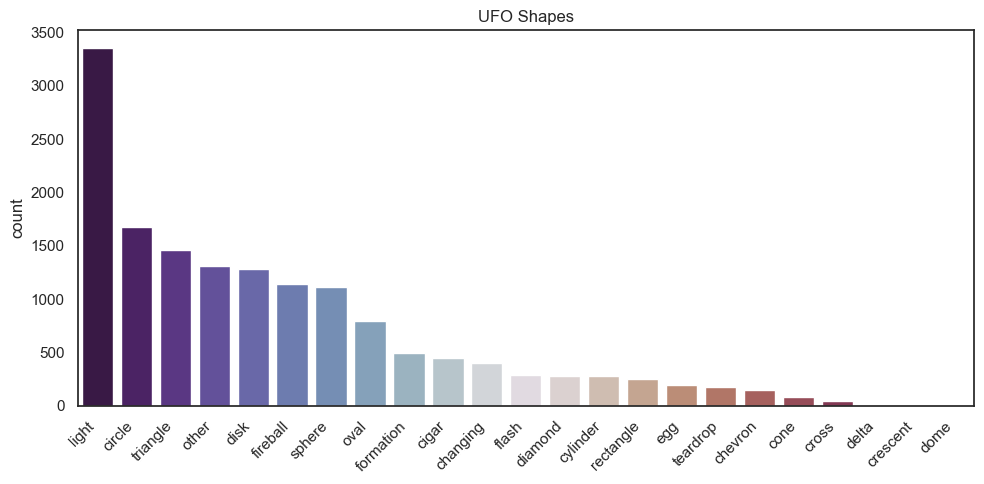

In [81]:
shape_counts = ufo_txt['shape'].value_counts().reset_index()

plt.figure(figsize = (10, 5))
sns.barplot(data = shape_counts, x = 'shape', y = 'count', palette = 'twilight_shifted')
plt.title('UFO Shapes')
plt.xticks(rotation = 45, ha = 'right') 
plt.xlabel('')
plt.tight_layout()
plt.show()

Notice that more distinct shapes such as cross, cone, teardrop, chevron, and diamond are reported the least while more ambiguous and simple shapes such as circle, triangle, light, and disk are reported more frequently. This is probably not a reflection of the UFO’s actual shape as it is difficult to see a UFO in detail due to its speed and distance from the observer.

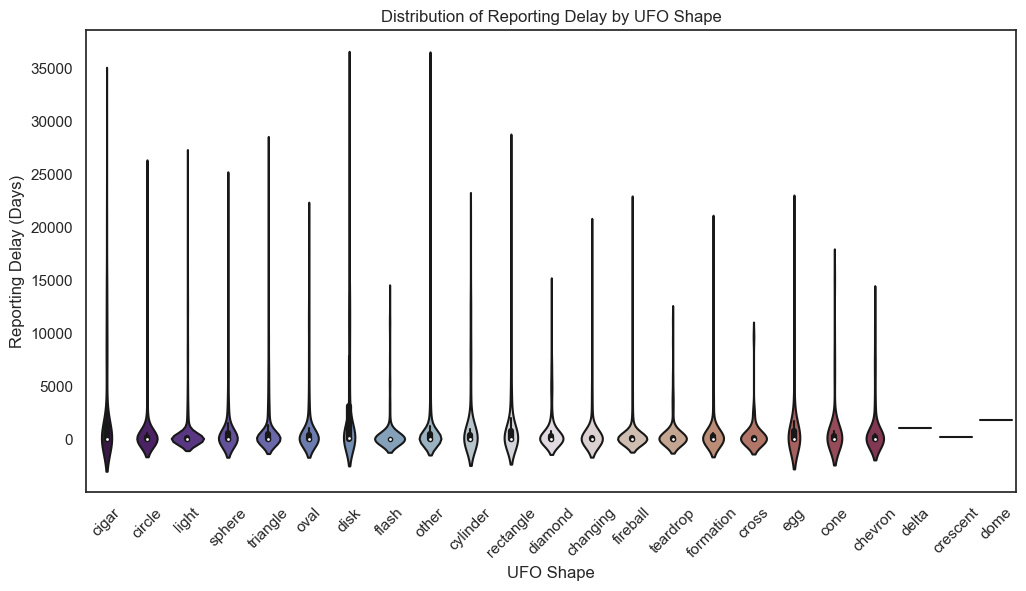

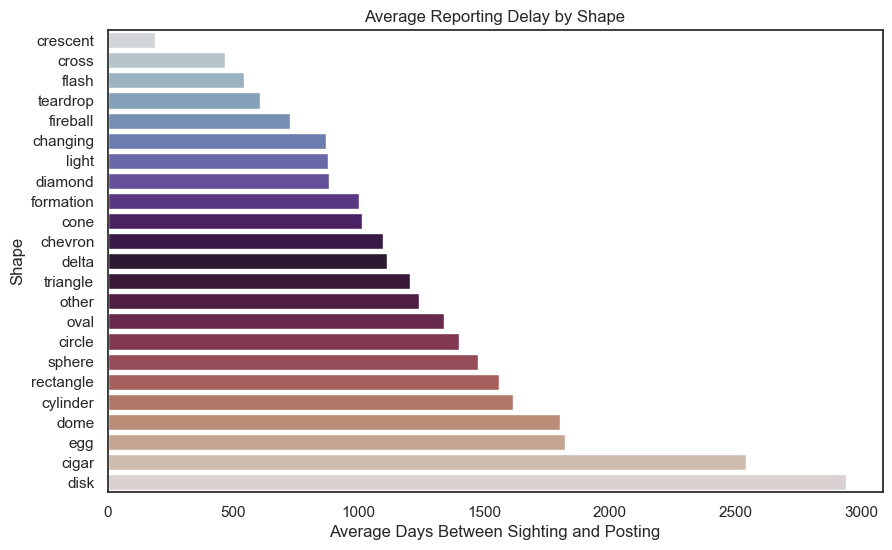

In [83]:
shape_reporting_delay = ufo.groupby('shape')['reporting delay'].median().reset_index()

# Violin plot for reporting delay by UFO shape
plt.figure(figsize = (12, 6))
sns.violinplot(data = ufo, x = 'shape', y = 'reporting delay', palette = 'twilight_shifted')
plt.title('Distribution of Reporting Delay by UFO Shape')
plt.xlabel('UFO Shape')
plt.ylabel('Reporting Delay (Days)')
plt.xticks(rotation = 45)

plt.show()

shape_delay = ufo_txt.groupby('shape')['reporting delay'].mean().sort_values()

# Bar graph for average reporting dalay by shape 
plt.figure(figsize = (10, 6))
sns.barplot(x = shape_delay.values, y = shape_delay.index, palette = 'twilight')
plt.xlabel('Average Days Between Sighting and Posting')
plt.ylabel('Shape')
plt.title('Average Reporting Delay by Shape')
plt.show()

- **Longest Reporting Delay:** Disk
    - This is possibly because a disk is a boring and regular shape. It can easily be confused with normal aerial objects like blimps or drones.
- **Shortest Reporting Delay:** Crescent
    - This is possibly because a crescent is not a shape that is commonly seen in the sky. The unusual and distinctive shape may cause immediate curiosity and cause someone to classify the object as unidentified, leading to quicker reporting.
- **Distinct vs General Shapes:** I noticed that UFO sightings featuring distinct shapes such as crosses, fireballs, chevrons, diamonds, and deltas tend to have quicker reporting times. While more general shapes like spheres, rectangles, ovals, eggs, and circles take longer to report. 

These findings suggest that the distinctiveness and novelty of UFO shapes play a role in the speed of reporting behavior. This could also relate to the earlier finding that the more ambiguous shapes could be a result of confusion on the observer's part (because of the speed and movement of the UFO). Meaning that they might not even be sure what they saw and this could cause someone to take longer to report it.

#### **Main Findings for UFOs vs Time:**
1. There was a large spike in UFO sightings and reportings after 1995
2. Canada is a popular tourist destination for aliens on vacation
3. Most people post about a UFO sighting immediately after it happens (especially if they are happy, scared, or angry)
4. Germans don't find UFOs exciting
5. People take longer to report sightings of UFOs with a boring or ambiguous shape. On the other hand, people are quick to report sightings of UFOs with an interesting shape.
***

<a id="vloc"></a>
## 2) UFOs vs Location
How can we analyze location with respect to UFO sightings?
* I want to see the ufo sightings plotted on a map
* I want to investigate UFO sightings in both hemispheres

### Sightings on a World Map
Questions to investigate 
* Where are sightings more concentrated?
* Are there any patterns to the sightings?

In [85]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

def plot_ufo_heatmap(xlim, ylim, title): 
    '''This function plots a heatmap of UFO sightings on a world map.
    The function calculates the density of UFO sightings using Gaussian Kernel Density Estimation (KDE)

    :param xlim: A tuple containing the lower and upper bounds of the longitude axis.
    :param ylim: A tuple containing the lower and upper bounds of the latitude axis.
    :param title: The title of the heatmap plot.
    :return: none
    '''
    fig, ax = plt.subplots(figsize = (13, 10))
    worldmap.plot(color = "darkgrey", ax = ax, edgecolor = 'none')
    xy = np.vstack([ufo['longitude'], ufo['latitude']])
    z = gaussian_kde(xy)(xy)

    idx = z.argsort()
    x, y, z = ufo['longitude'][idx], ufo['latitude'][idx], z[idx]

    scatter = ax.scatter(x, y, c = z, s = 1, cmap = "BuPu_r")

    cbar = plt.colorbar(scatter, ax = ax, orientation = 'horizontal', pad = 0.05)
    cbar.set_label('Density')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    
    plt.show()

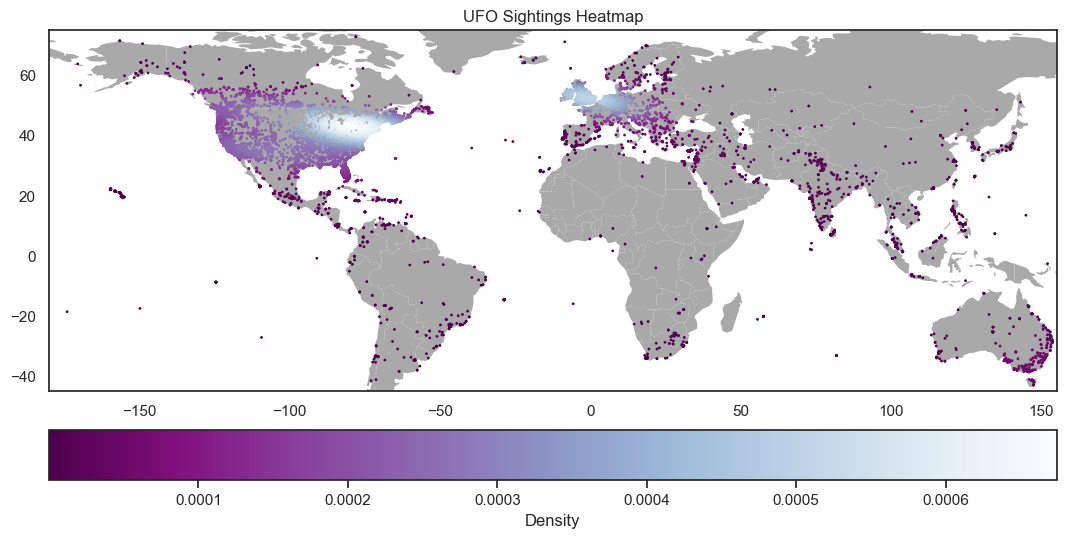

In [87]:
plot_ufo_heatmap([-180, 155], [-45, 75], "UFO Sightings Heatmap")

Most UFO sightings take place in the United States. Although this is to be expected as we previously saw this. These aliens seem to be picky as they are mostly visiting first-world countries (I'm just kidding, I would guess that the higher volume of sightings in these countries is related to the fact the topic of aliens is more popular in first-world countries).<br>
It seems like sightings are more concentrated along coastlines. It is possible this because Coastal areas often have higher population densities, and more people are outdoors. Several factors contribute to this:
* Coastal areas are a beautiful place to live. More people would want to live there, and the people that do live there probably spend more time outdoors.
* Coastal areas are popular tourist destinations. Also, tourists are usually observant of their surroundings as they are typically exploring and sightseeing.
* Coastal regions typically have significant maritime/outdoor activities, including shipping, fishing, and recreational boating. This places more people outside. Additionally, the presence of lights and activities on the water can sometimes be mistaken for UFOs, leading to more sightings being reported.
* The unique atmospheric conditions near coastlines, such as reflections off the water, unusual weather patterns, and increased visibility over open water, can contribute to more frequent sightings.
* Or maybe the aliens like to visit the beach (especially since they are on vacation)

In areas where sightings are more sparse, I notice that some sightings happen in clumps. This was curious to me so I wanted to apply the K-means clustering algorithm to see if I could investigate this a bit further.

In [93]:
def plot_clusters(db, xlim, ylim):
    '''This function plots the clusters of UFO sightings on a world map.
    The function calculates the clusters of UFO sightings using the K means clustering algorithm.

    :param db: A pandas DataFrame containing 'latitude' and 'longitude' columns.
    :param xlim: A tuple containing the lower and upper bounds of the longitude axis.
    :param ylim: A tuple containing the lower and upper bounds of the latitude axis.
    :return: none
    '''
    coordinates = db[['longitude', 'latitude']].dropna()
    num_clusters = 200
    
    # Initialize and fit KMeans clustering
    kmeans = KMeans(n_clusters = num_clusters, random_state = 42)
    kmeans.fit(coordinates)

    coordinates['cluster'] = kmeans.labels_

    fig, ax = plt.subplots(figsize = (13, 10))
    worldmap.plot(color="darkgrey", ax = ax, edgecolor = 'none')

    # Define colors for clusters
    cluster_colors = plt.cm.twilight.colors[:num_clusters]  # Use tab20 colormap for colors
    
    # Plot each cluster
    for cluster in range(num_clusters):
        cluster_data = coordinates[coordinates['cluster'] == cluster]
        color = cluster_colors[cluster % len(cluster_colors)]
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], s = 1, color = color)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("UFO Sightings Clusters")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

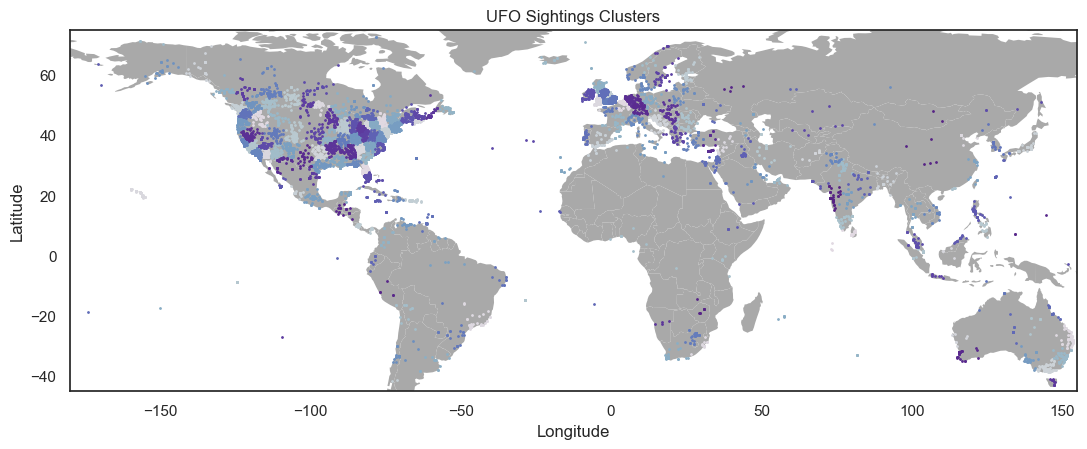

In [95]:
plot_clusters(ufo, [-180, 155], [-45, 75])

After applying K-means clustering and plotting these clusters on a world map, we can observe distinct clusters more easily. This visualization helps identify specific areas with higher concentrations of sightings, particularly in countries with sparse sightings. <br>
The clusters may show areas with a higher population density and better climate conditions to see UFOs. Or they could show
communities and cities where cultural beliefs make these areas more prone to claims of UFO sightings. <br>
But let’s be real here — this is clearly confirmation of aliens! These clusters obviously represent groups of people witnessing the same extraterrestrial event. It just makes too much sense, right? Aliens are definitely among us!

### Sightings vs Time of Year (Northern and Southern Heisphere)
Questions to investigate:
* Is there a time of year where sightings are more frequent for both hemispheres?
* Are there any possible conclusions we can draw from this?

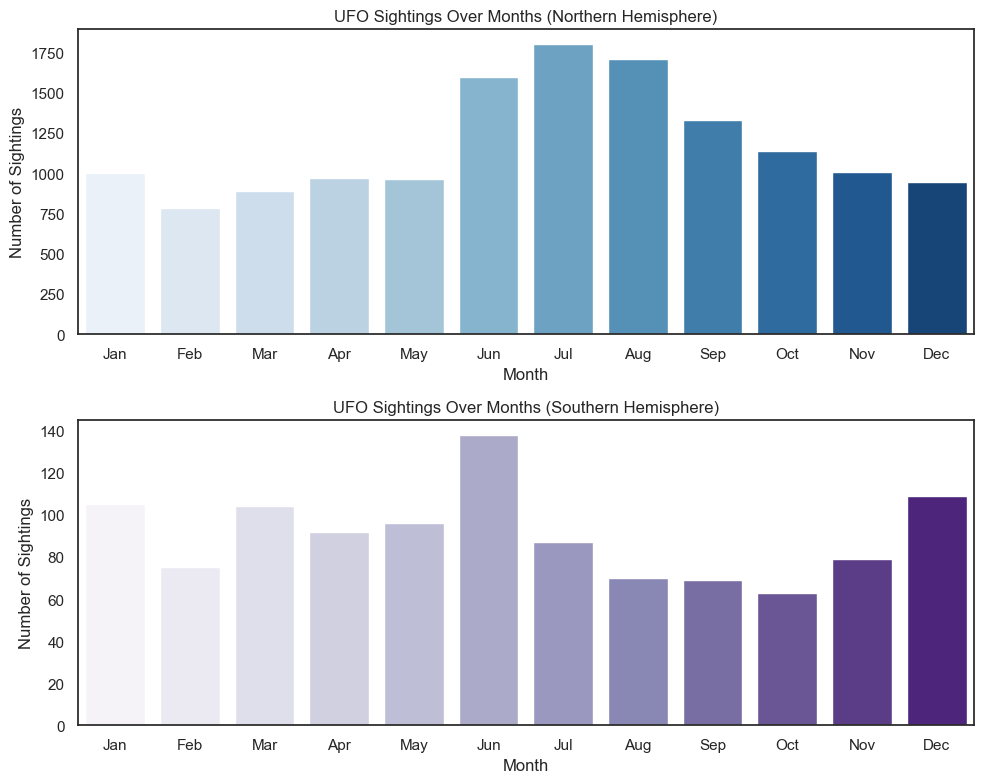

In [97]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 8))

# Plot for Northern Hemisphere
ufo_north = ufo[ufo["latitude"] >= 0].assign(month = ufo['datetime'].dt.month)
sightings_north_counts = ufo_north['month'].value_counts().sort_index()

sns.barplot(x = sightings_north_counts.index, y = sightings_north_counts.values, ax = axes[0], palette = 'Blues')
axes[0].set_title('UFO Sightings Over Months (Northern Hemisphere)')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Sightings')
axes[0].set_xticklabels(months)

# Plot Southern Hemisphere
ufo_south = ufo[ufo["latitude"] < 0].assign(month = ufo['datetime'].dt.month)
sightings_south_counts = ufo_south['month'].value_counts().sort_index()

sns.barplot(x = sightings_south_counts.index, y = sightings_south_counts.values, ax = axes[1], palette = 'Purples')
axes[1].set_title('UFO Sightings Over Months (Southern Hemisphere)')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Sightings')
axes[1].set_xticklabels(months)

plt.tight_layout()
plt.show()

**Northern Hemisphere** <br>
The months of June to November have the most sightings (these also happen to be the Summer and Autumn months in the northern hemisphere). This means a lot more people are outside during these months. July seems to be the most popular month. This might be a result of students beginning summer break at the end of June. In August the excitement of summer break fades and people go out less frequently but still a lot more compared to other months thus the number of people likely to see a UFO goes down slightly.

**Southern Hemisphere** <br>
The months with the most sightings are January, March, June, and December. Although January is a summer month in the southern hemisphere, it doesn’t have the most sightings as I expected. March is a Summer/Fall month while June and July are Winter months. So clearly the increase of UFO sightings is not solely due to an increase in summer activities.

**Possible Alien Holiday Month** <br>
What both these plots tell me is that aliens love to be out during June. This must be their version of the holiday season as everyone seems to be traveling on vacation (This would also explain why aliens seem to visit the beach so much!).

#### **Main Findings for UFOs vs Location**
1. Aliens love the beach
2. Aliens are 100% real (via the K-means clustering plot)
3. More people outside means more people are able to witness a UFO fly by
4. Aliens mostly visit first-world countries
5. Aliens have their holiday season around the month of June
***

<a id="vfeelings"></a>
## 3) UFOs vs Feelings
How can we analyze feelings with respect to UFO sightings? (By feelings I mean sentiment and emotion)

* I want to explore the relationship between sentiment and location on a world map
* I want to explore the relationship between emotion and location on a world map
* I want to investigate the relationship between feelings and different UFO shapes

### Investigation of the Relationship Between Location and Sentiment
Questions to investigate:
* How are different emotions spread out on a world map?
* How do the sentiment distributions differ in each country?

I am going to create a few of these plots of sentiments on a world map. I am going to create a function for this because later in my exploration I will need to take a closer look at how the sentiments are plotted within certain countries. For this section, I will focus on only doing all countries together.

In [99]:
def plot_world_sentiment(db, xlim, ylim, size, title):
    '''This function plots a world map and overlays scatter points representing UFO sightings 
    with colors corresponding to their sentiment (Positive, Negative, or Neutral). The map 
    is zoomed to the specified longitude and latitude limits.

    :param db: A pandas DataFrame containing 'longitude', 'latitude', and 'sentiment' columns.
    :param xlim: A tuple specifying the limits for the x-axis (longitude).
    :param ylim: A tuple specifying the limits for the y-axis (latitude).
    :param size: The size of the scatter points.
    :param title: A string containing the country name to be inserted into the title for the plot.
    :return: None
    '''
    col = ['#5d1749','rosybrown', '#adc3cd']
    fig, ax = plt.subplots(figsize=(10, 8))
    worldmap.plot(color = "grey", ax = ax, edgecolor = 'none')

    # Define colors for positive and negative sentiment
    color_map = {'Positive': col[0], 'Negative': col[1], "Neutral":col[2]}

    x = db['longitude']
    y = db['latitude']
    sentiment_column = 'sentiment' 
    sentiment = db[sentiment_column]

    # Plot points with color corresponding to sentiment (positive or negative)
    for s in ['Neutral', 'Positive', 'Negative']:
        mask = sentiment == s
        ax.scatter(x[mask], y[mask], c = color_map[s], s = size, label = s)

    ax.legend(markerscale=3.)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("UFO Sentiments Across " + title + "!")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

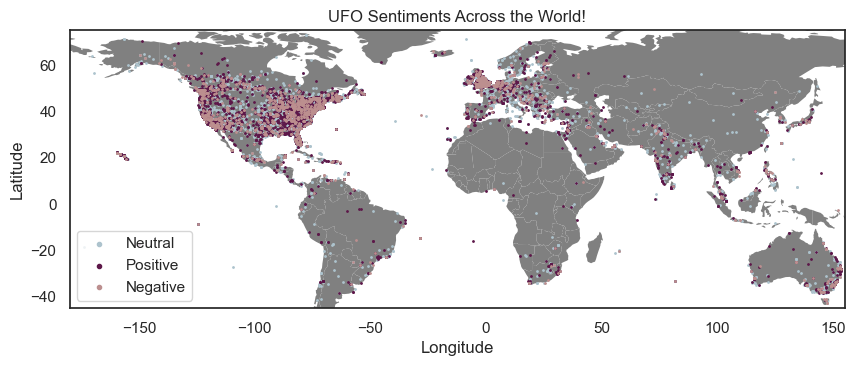

In [101]:
plot_world_sentiment(ufo_txt, [-180, 155], [-45, 75], 1, "the World")

I can see that negative and positive sentiments seem to be more concentrated closer to the most popular areas. While the neutral sentiment seems to be the most spread out. This makes me curious to see the percentage of sentiments for each country. This is what I will plot next.

In [103]:
def plot_sentiment_pie(db, country, ax): 
    '''This function creates a pie chart to visualize the distribution of sentiments.

    :param db: A pandas DataFrame containing 'sentiment' column.
    :param country: A string with the country name
    :param ax: A matplotlib Axes object where the pie chart will be plotted.
    :return: None
    '''
    col = ['#adc3cd','rosybrown', '#5d1749']
    counts = db['sentiment'].value_counts()
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', wedgeprops={"linewidth": 1, "edgecolor": "white"}, startangle=140, colors=col)
    ax.set_title(country, fontweight="bold")

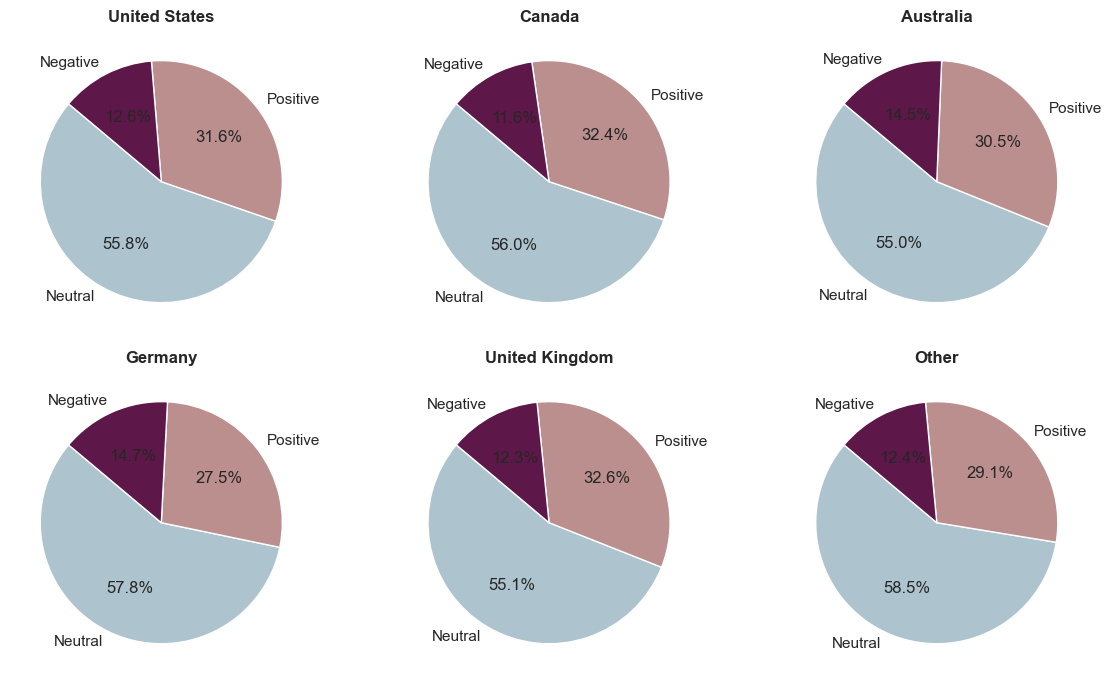

In [105]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

# Plot a pie charts
plot_sentiment_pie(ufo_text_us, 'United States', axs[0, 0])
plot_sentiment_pie(ufo_text_ca, 'Canada', axs[0, 1])
plot_sentiment_pie(ufo_text_aus, 'Australia', axs[0, 2])
plot_sentiment_pie(ufo_text_ger, 'Germany', axs[1, 0])
plot_sentiment_pie(ufo_text_uk, 'United Kingdom', axs[1, 1])
plot_sentiment_pie(ufo_text_else, 'Other', axs[1, 2])

plt.tight_layout()
plt.show()

All of these distributions are pretty much the same as they are extremely close.
- **Country with most Negative Sentiment:** Australia (14.5%)
- **Country with most Positive Sentiment:** United Kingdom (32.6%) - closely followed by Canada (32.4%)
- **Country with most Neutral Sentiment:** Other (58.5%)
<br>
<br>
- **Most Popular Sentiment:** Neutral
    - A lot of the comments are purely descriptive (for example "I went outside to call my cat approximately between or at night and looking up at the stars as I often do a fireball colored"). This would result in a neutral sentiment score
- **Middle Sentiment:** Positive 
    - The only reason this isn't higher is because a lot of people were solely descriptive. But its clear that deep down most people felt positively. 
- **Least Popular Sentiment:** Negative
    -  This makes sense. Who would feel negatively towards aliens? They're so cool!

**What does this tell us?** <br>
As we have concluded previously, Earth is a favorite vacation spot for extraterrestrial tourists. The bulk of neutral sentiments suggests that people have grown accustomed to seeing their alien buddies drop by. The frequent encounters with UFOs may have become as ordinary as spotting a pigeon in the park.
However, not everyone is as welcoming. There's always that small group of folks who grumble about tourists. You know, the ones who roll their eyes at the selfie sticks and "I ♥ Earth" T-shirts. This might explain the small proportion of negative sentiments and emotions. There is clearly no other explanation (because everyone knows aliens are cool).
But overall, it seems that most people are either neutral or quite happy to see our alien friends pop by for a visit.

Now I want to investigate the emotions to get a deeper look into where these sentiments come from.
### Investigation of the Relationship Between Location and Emotion
Cultural attitudes towards the unknown and otherworldly phenomena can vary across different countries, shaping how individuals interpret and react to such events. <br>
Questions to investigate:
* How are different emotions spread out on a world map?
* What emotions are most popular in every country?
* What are the distributions of these emotions?

In [108]:
def plot_emotions_on_map(ufo_txt):
    '''Plot scatterplot of each emotion on a geographical map.

    :param ufo_txt: DataFrame containing UFO data with emotion information.
    :return: None
    '''
    emotion_colors = {'Angry': '#953250','Fear': '#5b3196','Happy': '#c48065','Sad': '#759ac1','Surprise': '#ddd1d1'}
    geometry = [Point(xy) for xy in zip(ufo_txt['longitude'], ufo_txt['latitude'])]
    
    geo_df = gpd.GeoDataFrame(ufo_txt, geometry = geometry)
    fig, ax = plt.subplots(figsize = (12, 10))
    worldmap.plot(ax = ax, color = 'darkgrey', edgecolor = 'none')

    # Plot each emotion
    for emotion in ['Happy', 'Fear', 'Angry', 'Sad', 'Surprise']:
        emo_df = geo_df[geo_df['emotion'] == emotion]
        emo_df.plot(ax = ax, markersize = 2, label = emotion, color = emotion_colors[emotion])

    plt.title('Geographical Distribution of Emotions')
    plt.xlim([-180, 155])
    plt.ylim([-45, 75])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(title='Emotion')

    plt.show()

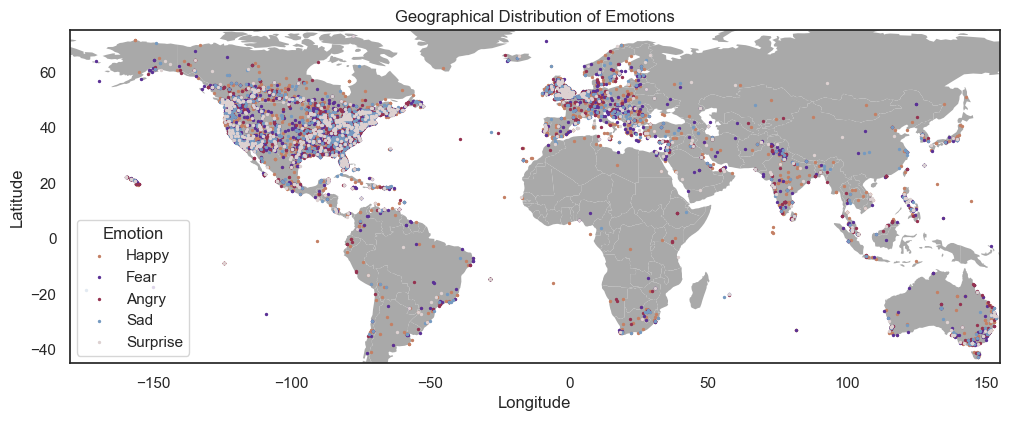

In [114]:
plot_emotions_on_map(ufo_txt)

Looking at the plot I just made, it is hard to fully tell how the emotions are dispersed inside each country. I do notice that in the United States and Europe, the surprised people seem to occur in slight clusters. This could hint at communities of people where the attitudes toward aliens are more skeptical and non-believing. But keep in mind this is just a very loose theory.

In the interest of learning more, I want to look into the relationship between each country and each emotion. I will use a heatmap for this. But keeping in mind the fact that the data is not evenly distributed in each country, I will normalize the data so that each row in the heatmap simply shows how the emotions are distributed within that country. 

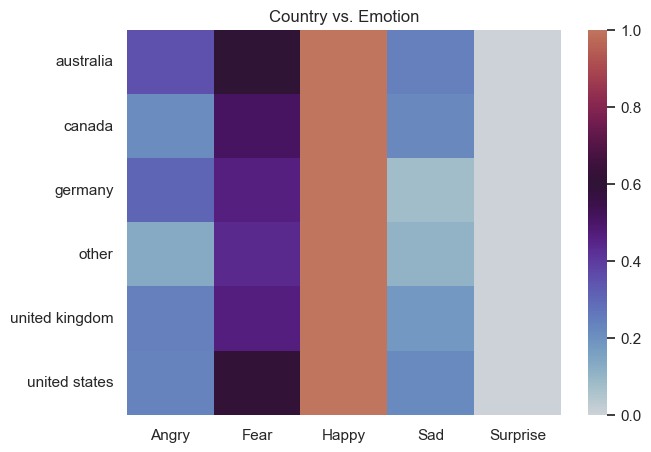

In [116]:
shape_emotion_counts = ufo_txt.groupby(['country', 'emotion']).size().unstack(fill_value=0)
normalized_data = shape_emotion_counts.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

plt.figure(figsize = (7, 5))
sns.heatmap(normalized_data, cmap = cropped_cmap)
plt.title('Country vs. Emotion')
plt.xlabel('') 
plt.ylabel('') 
plt.show()

* All the countries seem to have the same ranking in terms of which emotion is most common. This is intersting. I want to investigate this further.
* Happy is the most common emotion. And this makes sense because we saw that most people report UFO sightings immediatley and we also saw that people who were Happy about the sightings were the quickest to report about them.
* Suprise is the least popular emotion and this also makes sense because it was the emotion that took the largest report delay and we found that big report delays are less common.

I want to see the distribution of emotions as well as the counts for emotions for each country. For this, I will create a function to plot bar graphs with this information.

In [118]:
def plot_emotion_bar(db, country, ax): 
    '''This function creates a bar chart to visualize the distribution of emotions.

    :param db: A pandas DataFrame containing 'emotion' column.
    :param country: A string with the country name
    :param ax: A matplotlib Axes object where the bar chart will be plotted.
    :return: None
    '''
    emotion_counts = db['emotion'].value_counts().sort_index()
    sns.barplot(x = emotion_counts.values, y = emotion_counts.index, ax = ax, palette = ['#953250', '#5b3196','#c48065', '#759ac1', '#ddd1d1'])
    ax.set_title(country, fontweight = "bold")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel("")
    ax.set_xlabel("Count")
    
    # Add percent labels to bars
    for i, count in enumerate(emotion_counts.values):
        percent = (count / emotion_counts.sum()) * 100
        label = f"{percent:.1f}%"
        ax.text(count + 0.5, i, label, color='black', fontsize=10)

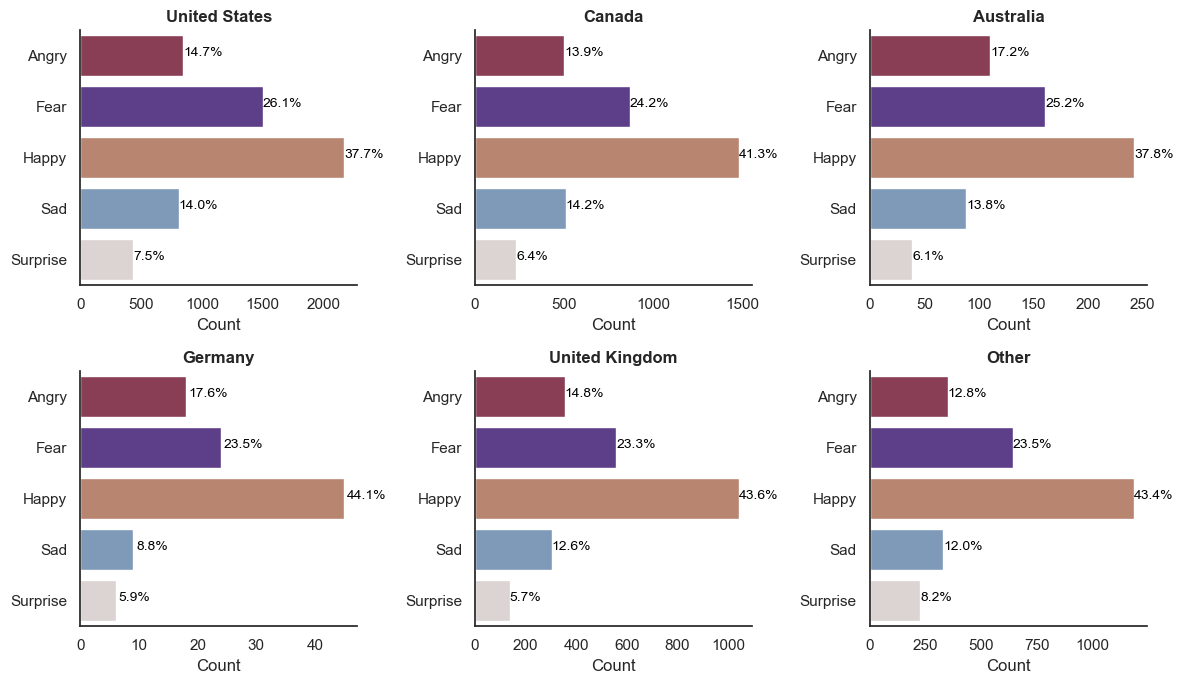

In [120]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

#Plot bar charts
plot_emotion_bar(ufo_text_us, 'United States', axs[0, 0])
plot_emotion_bar(ufo_text_ca, 'Canada', axs[0, 1])
plot_emotion_bar(ufo_text_aus, 'Australia', axs[0, 2])
plot_emotion_bar(ufo_text_ger, 'Germany', axs[1, 0])
plot_emotion_bar(ufo_text_uk, 'United Kingdom', axs[1, 1])
plot_emotion_bar(ufo_text_else, 'Other', axs[1, 2])

plt.tight_layout()
plt.show()

Most Popular to Least Popular
1. **Happy** (*Most Happy:* Germany (44.1%), *Least Happy:* Australia & United States (37.8% & 37.7%))
    - The prevalence of happy emotions across all countries could be the result of the sense of wonder and curiosity often associated with sightings of unidentified flying objects. In other words, aliens spread joy wherever they go. (Except in Australia which we know from above, is famously anti-alien tourist).
2. **Fear** (*Most Scared:* United States (26.1%), *Least Scared:* Germany & Other (23.5%))
    - I blame this on doomsday movies and sensationalist news coverage. These often depict aliens as threatening or hostile, contributing to feelings of anxiety or fear among some observers. It is no coincidence that the United States has the highest amount of fearful encounters, with its front-row seats to Hollywood movies that sensationalize, villainize, and stereotype aliens! Have we learned nothing from the movie *Jaws* and how they portrayed sharks? The predominance of fear in the United States can also explain why it is tied with Australia as the least happy country to see aliens. 
3. **Angry** (*Most Angry:* Germany (17.6%), *Least Angry:* Other (12.8%))
    - Who knew that encountering beings from another planet could get people's blood boiling? Maybe it's because they never bring intergalactic pizza with them when they visit. Another possible explanation for the anger is some people may be frustrated by what they perceive as hoaxes or misinformation, while others may resent the attention given to UFO sightings instead of more pressing issues. As we saw earlier from our graph depicting the delay in reporting time, germans don't seem to be the most interested in alien-related news. So I'm sure they deem other news as more important. 
4. **Sad** (*Most Sad:* Canada (14.2%), *Least Sad:* Germany (8.8%))
    - As we know, aliens love to visit Canada (the friendliest place this side of the Milky Way!). This could explain why Canada has the most melancholic UFO encounters. They can't help but shed a tear or two when their alien friends fly off into the sunset. Maybe they'd be less sad if the aliens stopped by and played a round of intergalactic hockey with them before they went.
5. **Surprise** (*Most Surprised:* Other (8.2%), *Least Surprised:* United Kingdom (5.7%))
    - Lastly, it is expected that surprise is the least common emotion for alien encounters. When Earth becomes a hot tourist destination for extraterrestrial beings, encountering aliens is about as surprising as finding a missing sock in the laundry.

### Investigation of Relationship Between Feelings and UFO Shape
Questions to investigate:
* What happens when we investigate shape and sentiment?
* What happens when we investigate shape and emotion?

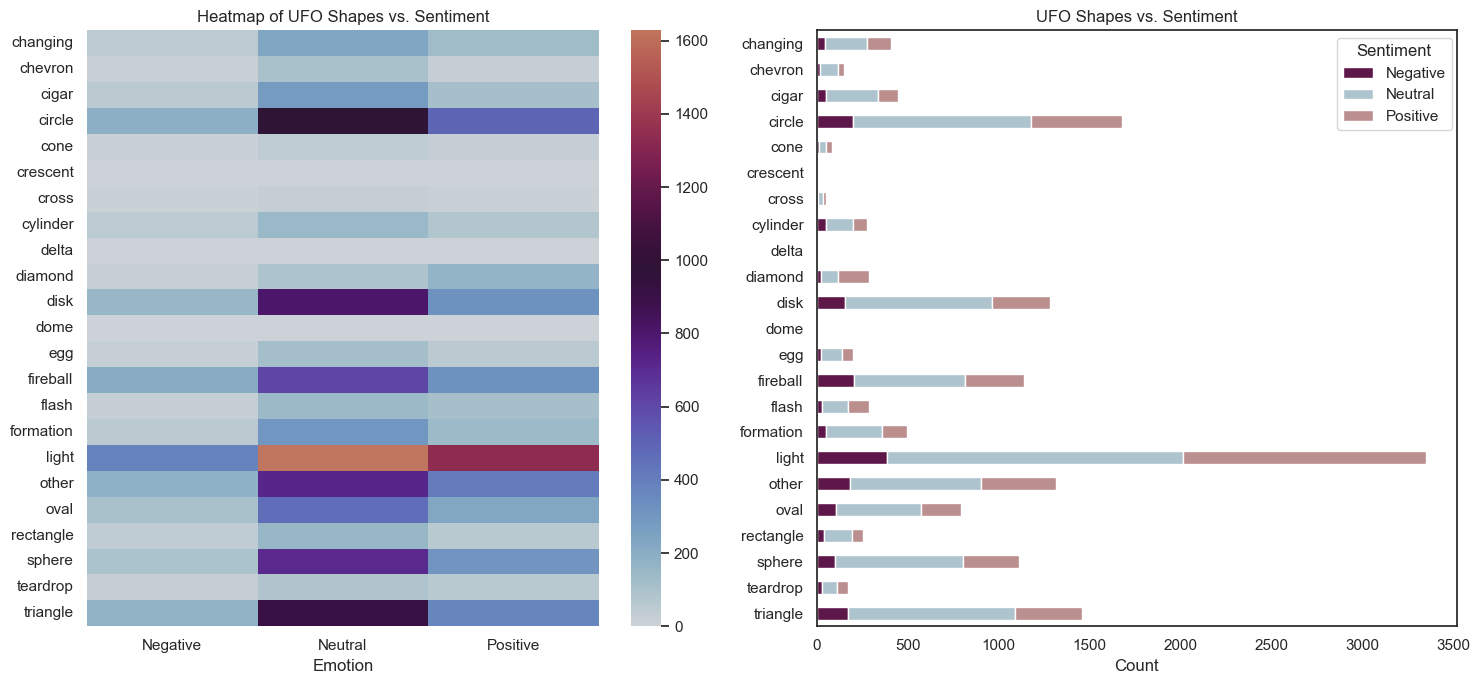

In [123]:
shape_sentiment_counts = ufo_txt.groupby(['shape', 'sentiment']).size().unstack(fill_value = 0)
shape_sentiment_counts_light = ufo_txt[ufo_txt['shape'] != 'light'].groupby(['shape', 'sentiment']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1) # Heatmap
sns.heatmap(shape_sentiment_counts, cmap = cropped_cmap)
plt.title('Heatmap of UFO Shapes vs. Sentiment')
plt.ylabel('') 
plt.xlabel('Emotion') 

plt.subplot(1, 2, 2) #Stacked Bar Plot
shape_sentiment_counts.sort_index(ascending=False).plot(kind='barh', stacked=True, colormap = ListedColormap(['#5d1749','#adc3cd', 'rosybrown']), ax=plt.gca())
plt.title('UFO Shapes vs. Sentiment')
plt.legend(title = 'Sentiment', bbox_to_anchor = (0.8, 1), loc = 'upper left')
plt.ylabel('') 
plt.xlabel('Count') 

plt.tight_layout()
plt.show()

* The shape *light* has the highest percentage of positive sentiment which is notable. Also note that it was the most common shape (as we saw previously) and it was very high with neutral and positive. This makes sense as these were the two most popular sentiments for every country.
* Most (but not all) shapes have mostly neutral sentiments, followed by positive, and lastly negative.
* The shape *diamond* has more positive sentiments than neutral sentiments. This is the only shape where this is the case.

Now I will do the same for UFO shapes vs Emotion. But note that we have previously observed that the shape "light" has significantly more instances than the other shapes. So I will create the heatmap without including light so we can read the other shapes better. I will also create a stacked bar plot like I did above.

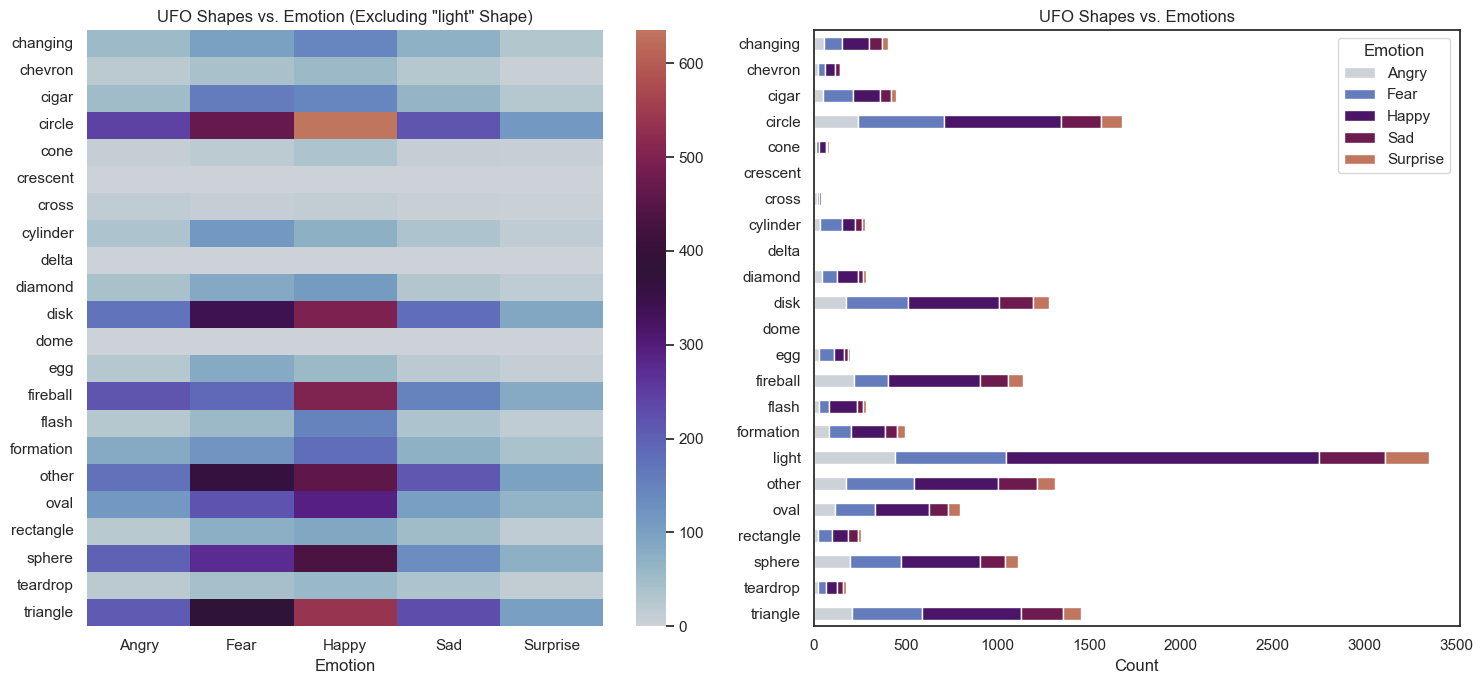

In [125]:
shape_emotion_counts = ufo_txt.groupby(['shape', 'emotion']).size().unstack(fill_value = 0)
shape_emotion_counts_light = ufo_txt[ufo_txt['shape'] != 'light'].groupby(['shape', 'emotion']).size().unstack(fill_value = 0)

plt.figure(figsize = (15, 7))

plt.subplot(1, 2, 1) #Heatmap
sns.heatmap(shape_emotion_counts_light, cmap = cropped_cmap)
plt.title('UFO Shapes vs. Emotion (Excluding "light" Shape)')
plt.ylabel('') 
plt.xlabel('Emotion') 

plt.subplot(1, 2, 2) #Stacked bar plot
shape_emotion_counts.sort_index(ascending = False).plot(kind = 'barh', stacked = True, colormap = cropped_cmap, ax = plt.gca())
plt.title('UFO Shapes vs. Emotions')
plt.legend(title = 'Emotion', bbox_to_anchor = (0.8, 1), loc = 'upper left')
plt.ylabel('') 
plt.xlabel('Count') 

plt.tight_layout()
plt.show()

* These plots are consistent with our distributions for emotions (previously observed)
* The shape *teardrop* seems to have very close distributions for all emotions (except surprise)
* The shape *flash* seems to be used in mostly descriptive comments as neutral dominates over the other emotions

#### **Main Findings for UFOs vs Emotion**
1. Most people are happy when they see an alien (who wouldn't be??)
2. All the countries have similar emotion and sentiment distributions (Mostly Neutral, Leastly Negative, Positive is in between)
3. Australia has the most alien tourist haters
4. Ranking of emotions: Happy, fear, angry, sad, surprised
5. Aliens are being negatively stereotyped in the media
7. UFOs shaped like diamonds are more likely to result in a positive reaction from a viewer
8. UFOs shaped like teardrops elicit mixed reactions from viewers|
***

<a id="comments"></a>
## 4) Comment Analysis
What can we find by analyzing the comments?
I will aim to answer these questions:
- What words are most used to describe UFO encounters?
- Does this change per country?
- Do these words tell us any new information about UFOs?

I am going to do 3 main things:
1. I will create a word cloud
2. I will plot the 5 most common words
3. I will plot the sentiments on a world map
   
I am also curious about how these differ per country, so I will repeat these steps for every country and see if we find anything interesting. Because I plan on doing this for each country, I will make a function to plot the first two graphs (I already have a function that plots the last one)

In [127]:
def plot_most_words(db, mask, pal):
    '''This function generates a word cloud for the words used in the 'comments' column.
    It then aggregates all words from the 'lemmed comments' column of the dataframe `db`, 
    counts the frequency of each word, and identifies the top 5 most common words. 
    
    :param db: A pandas DataFrame containing a 'lemmed comments' column with tokenized comments.
    :param mask: A numpy array used as a mask for the word cloud.
    :param pal: A color palette for the bar chart.
    :return: None
    '''
    all_words = ' '.join([' '.join(tokens) for tokens in db['lemmed comments']])
    word_counts = Counter(all_words.split(" "))
    top_words = word_counts.most_common(5)

    words, counts = [], []
    for word, count in top_words:
        words.append(word)
        counts.append(count)

    fig, ax = plt.subplots(1, 2, figsize = (10, 5))

    # Word Cloud
    wc = WordCloud(background_color = 'white', colormap = 'twilight', mask = mask, collocations = False).generate(all_words)
    ax[0].imshow(wc, interpolation = 'bilinear')
    ax[0].axis("off")

    # Bar Chart
    sns.barplot(x = words, y = counts, palette = pal, ax = ax[1])
    for i, count in enumerate(counts):
        ax[1].text(i, count, str(count), ha = 'center')
    ax[1].set_title("Top 5 Most Used Words", fontweight = "bold")
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].tick_params(axis = 'y', colors = 'white')

    plt.tight_layout()
    plt.show()

### All Countires 

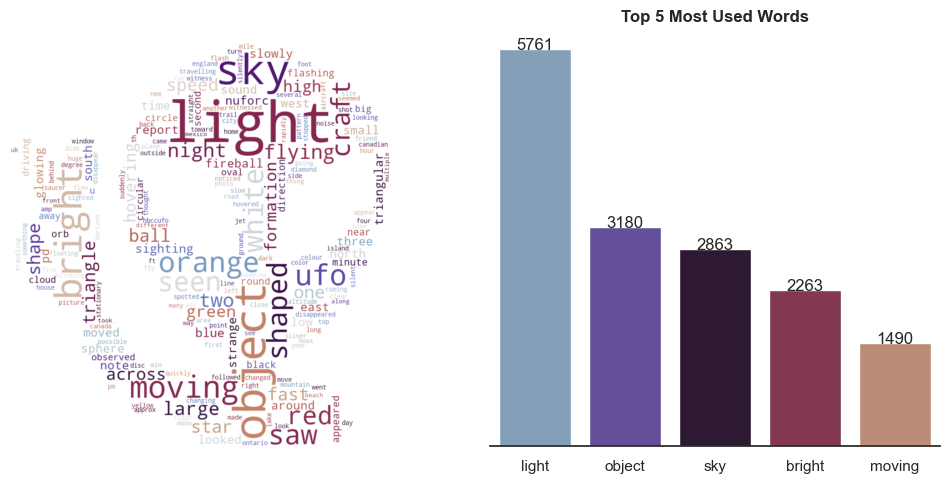

In [129]:
plot_most_words(ufo_txt, ufo_mask, 'twilight')

**Words** 
* **Top 5:** light, object, sky, bright, moving
* Wordcloud has mostly descriptive words
* **Notable words:**
    * *red*, *orange*, and *white*: These are possible UFO (or UFO light) colours
    * *nuforc*: which is the National UFO Reporting Center (__[NUFORC](https://en.wikipedia.org/wiki/National_UFO_Reporting_Center)__)
    * *night*: this implies that a lot of UFOs were seen at night (also notice the absence of words like day, sun, sunny)
    * *speed*, *fast*: the UFOs were traveling fast
    * *moving*: the UFO is moving rather than staying still

### Canada 

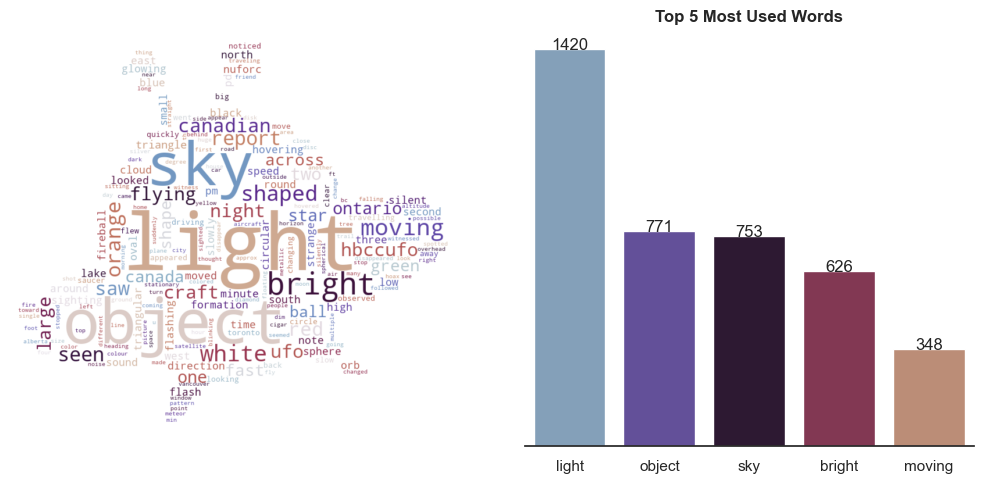

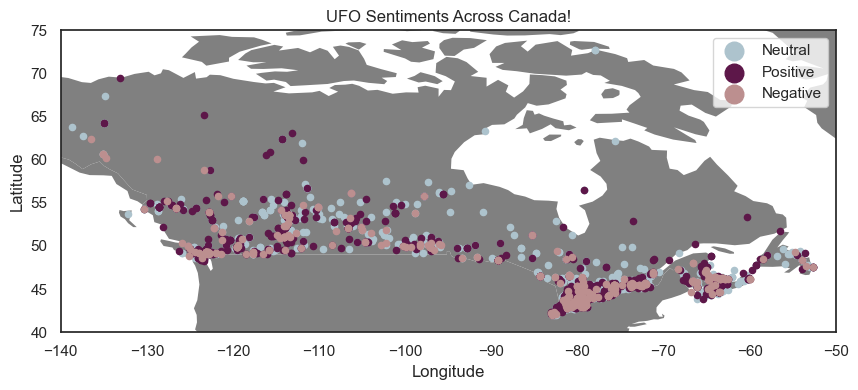

In [131]:
plot_most_words(ufo_text_ca, ufo2_mask, "twilight")
plot_world_sentiment(ufo_text_ca, [-140, -50], [40, 75], 20, "Canada")

**Words** 
* **Top 5:** light, object, sky, bright, moving
* Wordcloud has mostly descriptive words
* **Notable words:**
    * *hbcc ufo*: (Houston, British Columbia, Canada UFO) is a research and reporting organization focused on UFO sightings and related phenomena
    * *orange*, *white*, *green*, *red*: possible UFO colours (there are other colours but these are the biggest ones)
    * *report*: remember Canada was the second fastest country to report UFO sightings
    * *night*: this implies that a lot of UFOs were seen at night (also notice the absence of words like day, sun, sunny)
    * *lake*: some observations possibly took place by the water

**Sentiments**
* The negative sentiments seem to be in clusters.
* The negative sentiments seem to be more concentrated along the border between Canada and the United States
* There is also a cluster of negative sentiments in Toronto and New Brunswick  

### Australia

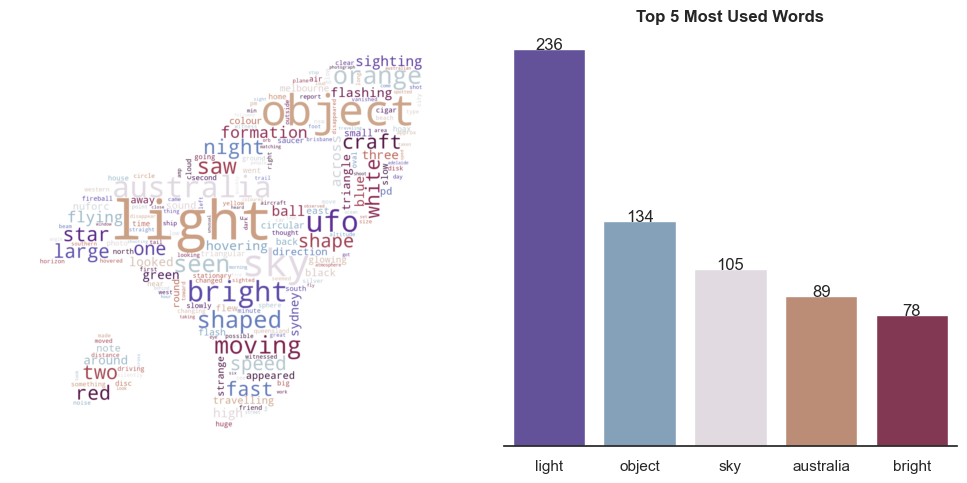

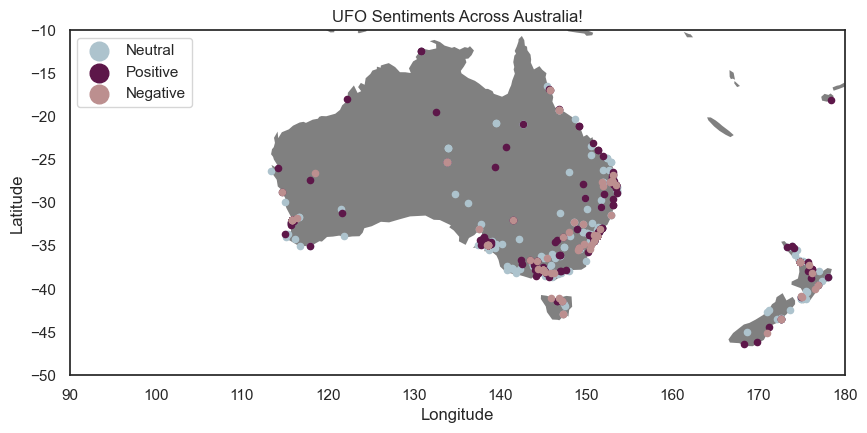

In [133]:
plot_most_words(ufo_text_aus, rocket_mask, "twilight_shifted")
plot_world_sentiment(ufo_txt, [90, 180], [-50, -10], 20, "Australia")

**Words** 
* **Top 5:** light, object, sky, Australia, bright
* Wordcloud we mostly see descriptive words
* **Notable words:**
    * *orange*, *red*, *white*: possible UFO colours
    * *speed*, *fast*: could be related to how the UFO moved
    * *moving*: the UFO is moving rather than staying still

**Sentiments**
* A lot of the sightings are very heavily concentrated along coastlines (perfect for vacation!)
* Negative sentiments seem to appear in slight clusters while neutral and positive sentiments are more spread out.

### United States

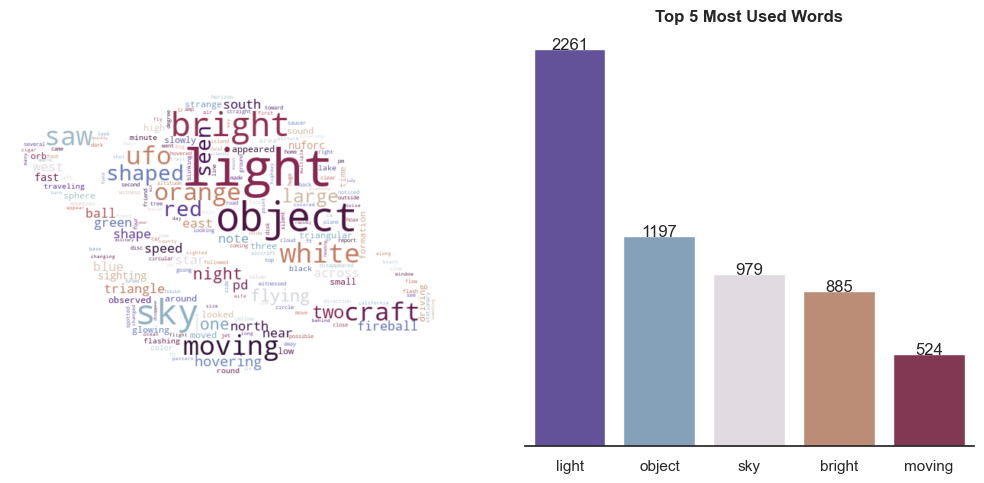

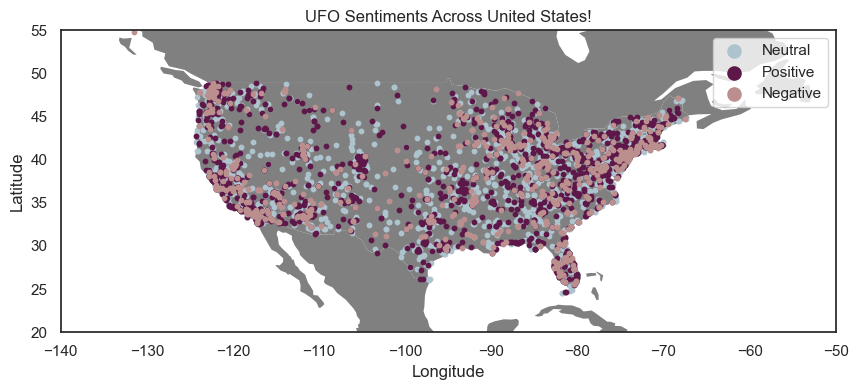

In [137]:
plot_most_words(ufo_text_us, saturn_mask, "twilight_shifted")
plot_world_sentiment(ufo_text_us, [-140, -50], [20, 55], 10, "United States")

**Words** 
* **Top 5:** light, object, sky, bright, moving 
* Wordcloud we mostly see descriptive words.
* **Notable words:**
    * *orange*, *white*, *red*: possible UFO colours
    * *object*: probably the result of comments like *"then object flew by"*
    * *bright*: UFO is described as bright
    * *night*: this implies that a lot of UFOs were seen at night (also notice the absence of words like day, sun, sunny)
    * *moving*: the UFOs were moving
    * *fast*: the UFOs were traveling fast
    * *nuforc*: which is the National UFO Reporting Center
      
**Sentiments**
* The neutral sentiment seems to be most spread out, the positive sentiment is slightly more concentrated in more popular areas, and the negative sentiment is even more concentrated in popular areas. 
* The negative sentiments seem to be making little clumps.

### Germany

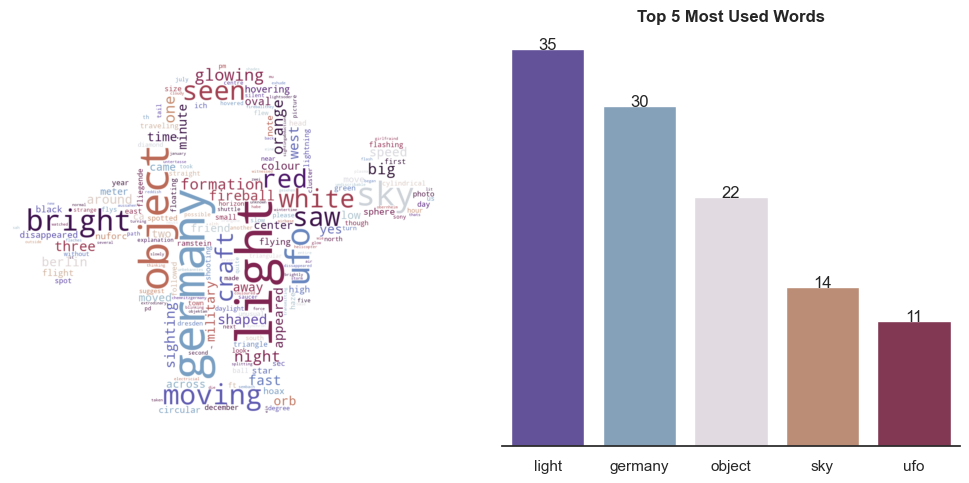

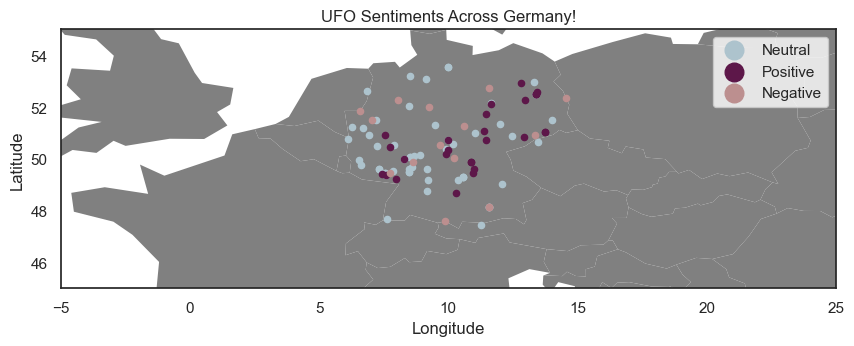

In [139]:
plot_most_words(ufo_text_ger, astro_mask, "twilight_shifted")
plot_world_sentiment(ufo_text_ger, [-5, 25], [45, 55], 20, "Germany")

**Words**
* **Top 5:** light, Germany, object, sky, ufo
* In wordcloud we mostly see descriptive words.
* **Notable words:**
    * *white*, *orange*, *red*: possible UFO colours
    * *object*: probably the result of comments like *"then object flew by"*
    * *night*: this implies that a lot of UFOs were seen at night (also notice the absence of words like day, sun, sunny)
    * *bright*, *glowing*: UFO descriptions
    * *hoax*: this backs up my theory as to why a larger percentage of germans were angry and also my theory as to why they take longer to post. They are not the strongest believers in alien life! (It is one of the smaller words but it is there!)
    * *moving*: the UFOs were moving rather than staying still

**Sentiments**
* The sentiments seem to be randomly scattered

### United Kingdom

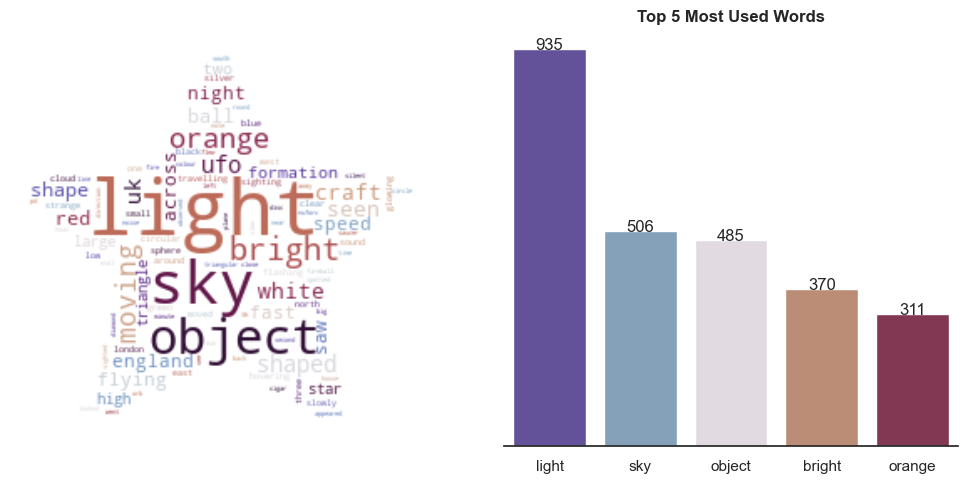

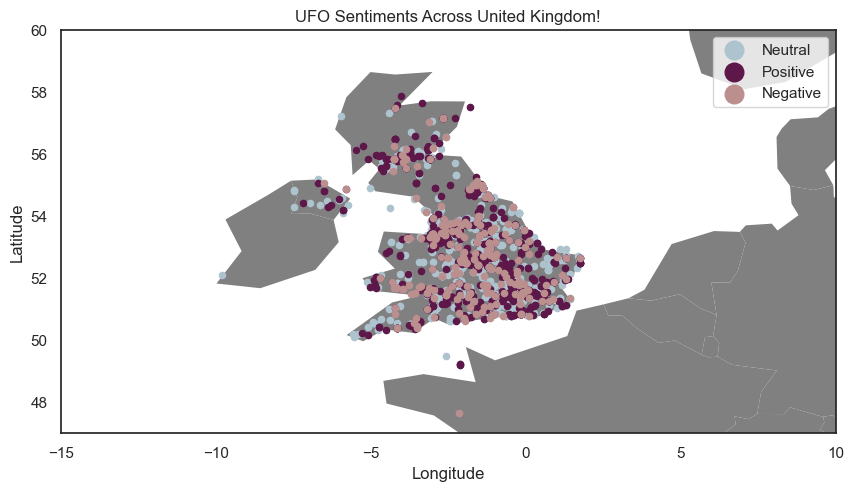

In [141]:
plot_most_words(ufo_text_uk, star_mask, "twilight_shifted")
plot_world_sentiment(ufo_text_uk, [-15, 10], [47, 60], 20, "United Kingdom")

**Words**
* **Top 5:** light, sky, object, bright, orange
* Wordcloud we mostly see descriptive words
* **Notable words:**
    * *orange*, *red*, *white*: possible UFO colours
    * *object*: probably the result of comments like *"then object flew by"*
    * *night*: this implies that a lot of UFOs were seen at night (also notice the absence of words like day, sun, sunny)
    * *moving*: the UFOs were moving
    * *bright*: UFO is described as bright
    * *speed*, *fast*: could be related to how the UFO moved
    * *slowly*, *hovering*: so maybe the UFO would sometimes pause and go slower

**Sentiments**
* The sentiments seem to be randomly scattered

### Other Countries

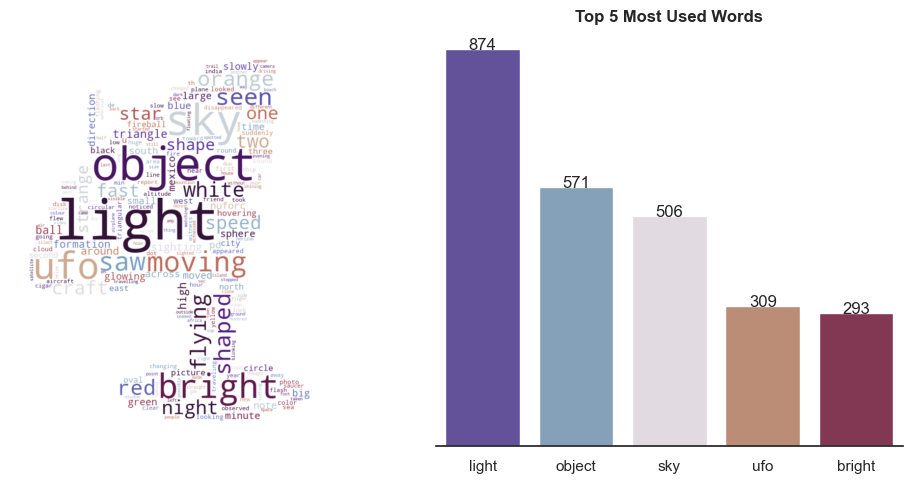

In [143]:
plot_most_words(ufo_text_else, sattelite_mask, "twilight_shifted")

**Words**
* **Top 5:** light, object, sky, ufo, bright
* In wordcloud we mostly see descriptive words.
* **Notable words:**
    * *orange*, *red*: possible UFO colours
    * *object*: probably the result of comments like *"then object flew by"*
    * *fast, speed*: could be related to how the UFO moved
    * *night*: this implies that a lot of UFOs were seen at night (also notice the absence of words like day, sun, sunny)
    * *bright*: UFO is described as bright
    * *nuforc*: which is the National UFO Reporting Center

#### **Conclusion**
**Words** <br>
A lot of these results are pretty similar. The most common word used for all countries and each country individually is light. Light also happens to be one of the shapes of a UFO. Not only that, it also happens to be the most common UFO shape by far. So it is no surprise that it is the most commonly used word. **Light**, **object**, and **sky** are consistently the top 3 most used words (except for Germany whose top 4 are light, germany, object, sky). The words bright and UFO also show up often. As you can see from analyzing the word clouds, the most used words seem to be descriptive. Additionally, the top 5 most used words are all descriptive words. This is consistent with our previous discovery that the most popular sentiment was neutral.<br>
**Frequently reoccurring words:**
* fast, speed, moving
* orange, white, red
* night
* large
  
**Sentiment** <br>
It is often common to find that the neutral sentiments are the most spread out. Negative sentiments seem to be more concentrated in more populated areas and they sometimes seem to occur in little clumps. These clumps could be the result of communities that share the same attitudes towards aliens. However this is not always the case as in some countries, all sentiments seem to be randomly scattered.

#### **Main Findings for Comment Analysis**
* UFOs probably have orange, red, and white lights
* UFOs move quickly
* UFO sightings often happen at night
* A lot of people report their sightings to NUFORC
***

<a id="summary"></a>
# Overall Summary
To summarize, I will answer the questions I posed in each section and I will create a list of my main findings for each section.
### 1) UFOs vs Time
#### Summary for Sightings, and Reporting Over the Years 
1. Is there a steady increase in UFO sighting rates over the years?:
    - Yes there is a steady increase. This could be due to internet becoming more accessible, several alien themed events happening in pop culture, and the 
rise in popularity around certain conspiracy theories.
2. Is there a steady increase in reporting rates over the years? (and how about for different countries?) What are some possible reasons for this?
    - No the increase is not steady. It fluctuates up and down. The initial spike in reportings is probably a result of all the sightings that took place before the internet was accessible.
    - All countries had a spike in postings around the year 2012. This could be due to the popular theory that the end of the world was going to take place in december 2012.
      
**Findings**
- There was a large spike in UFO sightings and reportings after 1995
- Canada was a hot tourist destination for aliens around 2003-2007
- There was a spike in UFO sightings and reportings around 2012

#### Summary for My Investigation on Reporting Delays
1. How quickly do people usually post?:
    -  Most people post about the UFO sighting immediatley. 
2. Does the reporting delay differ from country to country?
    - Yes. Germany takes the longest by far and the UK is the quicketst. This is probaly due to cultural attitudes and interest in the topic of UFOs and extraterrestrial life.
    - The United States took surprisingly long to report a UFO sighting. This could be the result of factors like fear of being seen as a "nutjob", fast paced american lifestyle, and thoroughness in collecting accurate accounts of the encounter.
3. Do different UFO shapes effect the reporting delay? (Maybe some shapes are scarier than others)
    - Yes. More boring shapes seem to be less urgent to talk about. Distinct and unique shapes seem to result in a shorter posting time. This could be because unique shapes like crosses, fireballs, chevrons, diamonds, and deltas result in intrigue and uncertainty, causing witnesses to seek validation and answers faster. While more general shapes like spheres, rectangles, ovals, eggs, and circles take longer to report. This might be because they don't elicit the same excitement and curiosity as the distinct shapes. 
4. How does peoples emotions affect reporting delay?
   - People who feel strong emotions like happy, fear and anger tend to report the quickest.
      - Happy people often want to share their excitement
      - Scared people want to find comfort in others
      - Angry people want to rant and blow off steam
   - As for the slower emotions:
     - Sadness drains our energy, usually making a person operate slower than normal
     - Surprised people are taken off guard and might take a bit longer to process what happened. It is possible they do not fully understand what they witnessed until they process it first.
     
**Findings**
* Fastest to slowest reporting time (Countries): United Kingdom, Canada, Australia, United States, Germany
* Fastest to slowest reporting time (Emotions): Angry, Happy, Fear, Sad, Surprise
* Distinct and unique shapes were reported about the quickest, boring and common shapes were reported about the slowest.
  
### 2) Ufos vs Loaction
#### Summary for Sightings on a World Map
1. Where are sightings most concentrated? 
   - Sightings are most popular in first world countries (or rather the topic of aliens is more popular in first world countries)
   - Sightings seem to happen along coastlines. This could be due to tourism, desire to live there, increased amount of maritime/outdoor activities in these areas, or aliens the fact that since the aliens are probably on vacation, they would like to visit the beach.
2. Are there any patterns to the sightings?
   - The sightings in more sparse areas seem to happen in clusters
   
**Findings**
- Aliens love the beach
- Aliens are 100% real (via the K-means clustering plot)
  
#### Summary for Sightings vs Time of Year (Northern and Southern Hemisphere)
3. Is there a time of year when sightings are more frequent for both hemispheres?
   - Yes. In the northern hemisphere, sightings seem to spike in the summer months. This could be due to warm weather, outdoor activities, or the school year ending.
   - In the southern hemisphere the most popular months are January, March, June, and December
     
**Findings**
- June is the most popular month for alien sightings (it is clearly an alien holiday month). A further possibility is that June is pride month and maybe aliens love to visit Earth and take part in Pride festivities!
  
### 3) UFOs vs Feelings
#### Summary of My Investigation of the Relationship Between Location and Sentiment
1. How are different sentiments spread out on a world map?
   - Negative and positive sentiments seem to be more concentrated closer to the most popular areas. While the neutral sentiment seems to be the most spread out
2. How do the sentiment distributions differ in each country?
   - All countries seem to have similar sentiment distributions

**Findings**
* Most popular to least popular sentiment: neutral, positive, negative
* The United Kingdom and Canada have the highest percentages of positive sentiments
* Australia is not a fan of alien tourists (it has the highest percentage of negative sentiments)

#### Summary of My Investigation of the Relationship Between Location and Emotion
3. How are different emotions spread out on a world map?
   - Generally, it looks like the emotions are all randomly spread out. But I noticed in the United States and Europe, the surprised people seem to occur in slight clusters. 
4. What emotions are most popular in every country?
   - Happiness is the most popular emotion in every country, and surprise is the least popular emotion in every country. 
5. What are the distributions of these emotions?
   - All countries have the same distributions

**Findings**
- Emotions ranked: Happy, scared, angry, sad, surprised
  - Note that this is very similar to the ranking for shortest to longest reporting time. 
- **Happy** (*Most Happy:* Germany, *Least Happy:* Australia & United States)
  - Aliens spread joy wherever they go (except Australia)
- **Fear** (*Most Scared:* United States, *Least Scared:* United Kingdom)
  - Hollywood unfairly portrays aliens in doomsday films
- **Angry** (*Most Angry:* Germany, *Least Angry:* Other)
  - Germans don't like hoaxes and misinformation
- **Sad** (*Most Sad:* Canada, *Least Sad:* Germany)
  - Canadians are sad that their alien friends don't stay and hang out forever
- **Surprise** (*Most Surprised:* Other, *Least Surprised:* United Kingdom)
  - Due to Earth's popularity as a vacation spot, people have grown accustomed to seeing aliens. This results in surprise being the least common emotion.
  
#### Summary of My Investigation on Feelings about UFO Shapes
6. What happens when we investigate shape and sentiment?
   - Most shapes have mostly neutral sentiments, followed by positive, then negative
   - The exception to this is the *diamond* shape
7. What happens when we investigate shape and emotions
   - these plots are consistent with the plot from the above question
   - The shape *flash* seems to mostly elicit neutral reactions

**Findings**
* The shape *light* has the highest percentage of positive sentiment.
* UFOs shaped like diamonds are more likely to result in a positive reaction from a viewer
* UFOs shaped like teardrops elicit mixed reactions from viewers
  
### 4) Comment Analysis
1. What words are most used to describe UFO encounters?
   - Light, object, and sky are consistently the top 3 most-used words
   - Other words that often appear in the top 5 are bright and ufo
2. Does this change per country?
   - For the most part, the countries have very similar top 5 words
3. Do these words tell us any new information about UFOs?
   - Yes. We learn new information about the colour and motion of UFOs.

**Findings**
* UFOs seem to be moving quickly for the most part
* Most UFOs are orange, white, or red (or have orange, white, or red lights)
* UFO sightings often happen at night
* UFOs can be large